In [9]:
import pathlib
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pathlib
from GPy.models import GPRegression
import GPy
import pickle
import matplotlib.colors as mcolors
from sklearn.neighbors import KernelDensity
import sys
sys.path.insert(0, "./../")
from src.ice_sheet import ice_sheet_runner
import random
from pathos.multiprocessing import ProcessingPool as Pool
import time
from src.utils import load_data, prep_data, predict_and_plot_SLC
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from pathos.multiprocessing import ProcessingPool as Pool
from scipy.stats import wasserstein_distance
from sklearn.utils import shuffle
import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette('colorblind')
mpl.rcParams['font.family'] = 'Arial'

In [10]:
data = load_data([0,151], datasets_folder="./../assets/v2_ice_sheet_simulation/", extension="_dt", version="vs")


In [11]:
def calculate_optimal_density(data, sample_size, resolution=2, mean_melt=2.2):
    mean_prior = 2.2
    prior_sigma = 0.5
    data_sub = data[data["resolution"] == resolution]
    data_sub = data_sub[data_sub["years"] == 150]
    X_m = np.random.lognormal(mean=mean_prior, sigma=prior_sigma, size=100).reshape(
        (-1, 1)
    )

    closest_points_indices = []
    for x_m_value in X_m[:sample_size].flatten():
        closest_point_index = (data_sub['melt_average'] - x_m_value).abs().argsort()[:1]
        closest_points_indices.append(closest_point_index.values[0])
    closest_points = data_sub.iloc[closest_points_indices]


    X, Y, X_m = prep_data(closest_points, X_m=X_m)
    kernel = GPy.kern.RBF(input_dim=1, ARD=True, lengthscale=[1], variance=1)
    model_gpy = GPRegression(X, Y, kernel=kernel, normalizer=True, noise_var=1)
    model_gpy.optimize()
    mean,var  = model_gpy.predict(X_m.reshape((-1, 1)))
    data_list = []
    for m,v in zip(mean,var):
        data_list += list(np.random.normal(m,np.sqrt(v),size=10))

    X_lin = np.linspace(0,500,100)[:, np.newaxis]
    kde = KernelDensity(kernel='gaussian',bandwidth=1).fit(np.array(data_list).reshape((-1,1))) #you can supply a bandwidth

    log_density_values=kde.score_samples(X_lin)
    y_opt_pdf=np.exp(log_density_values)
    # Calculate optimal CDF
    max_val = 400
    x = []
    y = []
    for thres in range(0,max_val,5):
        # Count how many elements in data list are abov thres
        # and divide by the total number of elements
        # to get the percentage of elements above thres
        x.append(thres)
        y.append(len([i for i in data_list if i > thres])/len(data_list))
    y_opt_cdf = np.array(y)
    return y_opt_cdf, y_opt_pdf, data_list

In [14]:
start = 2
budget_list = []
for i in range(30):
    new_start = int(start * (1.5))
    if new_start - start > 500:
        start += 500
    else:
        start = new_start
    budget_list.append(start)

mean_errors = {}
pdf_errors = {}
num_rep = 25
cost = {2:70,3:12,4:8,5:4,6:3,7:2,8:1}
for mean_melt, melt_label in [(2.2,10),(2.872,20),(3.52,40)]: #,
    opt_cdf,opt_pdf, observed_2k = calculate_optimal_density(data, 500, resolution=2, mean_melt=mean_melt)

    mean_errors[melt_label] = {}
    pdf_errors[melt_label] = {}

    for res in [2,3,4,5,6,7,8]:
        mean_errors[melt_label][res] = {}
        pdf_errors[melt_label][res] = {}
        for budget in budget_list:
            errors = []
            pdf_error_list = []
            num_points = budget//cost[res]
            if num_points < 1:
                mean_errors[melt_label][res][budget] = None
                pdf_errors[melt_label][res][budget] = None
                continue

            if num_points > 500:
                num_points = 500
            for _ in range(num_rep):
                y_opt_cdf, new_pdf, new_val = calculate_optimal_density(data, num_points, resolution=res, mean_melt=mean_melt)
                pdf_error_list.append(np.abs(opt_pdf-new_pdf).sum())
                errors.append(wasserstein_distance(observed_2k, new_val))

            mean_errors[melt_label][res][budget] = errors
            pdf_errors[melt_label][res][budget] = pdf_error_list

            print(f"Resolution: {res}, Samples: {num_points}, Mean Error: {pdf_errors[melt_label][res][budget]}")

pickle.dump(pdf_errors,open("fig_6.pkl","wb"))


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of

Resolution: 2, Samples: 1, Mean Error: [0.5847662176026762, 0.5750780420364252, 0.5119761558024207, 0.5119761558024154, 0.5119761558024172, 0.5847662176026734, 0.5847662176026741, 0.5750780420364238, 0.5119761558024196, 0.5119761558024184, 0.5750780420364238, 0.5847662176026727, 0.5847662176026748, 0.5119761558024184, 0.5119761558024166, 0.22982942321283245, 0.5847662176026727, 0.5119761558024154, 0.5847662176026762, 0.5119761558024214, 0.5847662176026713, 0.5750780420364238, 0.5119761558024172, 0.5119761558024178, 0.5119761558024184]


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of

Resolution: 2, Samples: 2, Mean Error: [0.1140980313717615, 0.5119761558821677, 0.11682299036033326, 0.5119761554776732, 0.33861951337818474, 0.5847662174048727, 0.5119761558266289, 0.22012033452730206, 0.5119761552389888, 0.5750780421032093, 0.5119761549634135, 0.10560947638536318, 0.09285914322552119, 0.5119761520457203, 0.34346019433903896, 0.33302761532704145, 0.1069078583771987, 0.11594524296016877, 0.511976156482484, 0.09970623980040336, 0.5119761556647402, 0.0978413554535844, 0.10852105102629803, 0.12077748705774508, 0.5119761581037029]


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.


Resolution: 2, Samples: 3, Mean Error: [0.5847662176026692, 0.5750780420364259, 0.511976155802657, 0.2562495002078402, 0.14348162837938022, 0.11020014150042959, 0.1162779516562614, 0.5119761558033934, 0.10513585093375513, 0.10965603616224291, 0.09963209796772174, 0.09752185510222368, 0.511976155801823, 0.34041944057683665, 0.11507322159878901, 0.5119761558031555, 0.1022137505053271, 0.10433103278113026, 0.13625212847929152, 0.3405443244221724, 0.19559643742504407, 0.1858204447725519, 0.2080992569379826, 0.12049063449284052, 0.33778630804958365]


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.


Resolution: 2, Samples: 4, Mean Error: [0.1855396252659191, 0.5119761592486879, 0.0784614392490999, 0.11153643323768232, 0.13474538751667786, 0.11018664864455963, 0.5119761560462895, 0.08696832397073839, 0.11889703503032162, 0.11111898338841386, 0.32799674126231304, 0.3347836893310837, 0.13624319034773258, 0.11021860924971733, 0.08528048272977533, 0.1274376006955682, 0.3502119089679804, 0.10969278435582377, 0.16466383637681473, 0.08712018691380503, 0.10585947924766598, 0.3434523764692078, 0.12036705451342213, 0.11092325606293887, 0.16940927329495833]
Resolution: 2, Samples: 6, Mean Error: [0.12142147611827482, 0.17126509655941097, 0.13353754684893732, 0.11910472557797892, 0.20459839547155173, 0.1428402867998917, 0.5119761558024136, 0.09763814282038324, 0.1813277454617265, 0.11471214991705847, 0.08735860017621276, 0.12239048615888043, 0.05114401512246727, 0.07466440799426957, 0.1096524400642191, 0.13570925381129786, 0.05216545321205962, 0.20060827062640166, 0.13965559855011558, 0.336623

 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of

Resolution: 3, Samples: 1, Mean Error: [0.255633957646504, 0.2556339576465053, 0.2556339576465043, 0.5812530141639187, 0.25563395764650576, 0.23402883274755085, 0.2556339576465049, 0.23402883274755132, 0.2556339576465045, 0.2556339576465043, 0.5812530141639187, 0.2556339576465051, 0.23402883274755074, 0.2556339576465038, 0.5812530141639187, 0.5812530141639173, 0.2556339576465037, 0.23402883274755085, 0.23402883274755165, 0.5812530141639181, 0.2556339576465047, 0.5812530141639166, 0.23402883274755054, 0.4996666793136344, 0.25563395764650565]


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of

Resolution: 3, Samples: 1, Mean Error: [0.255633957646506, 0.25563395764650365, 0.5812530141639173, 0.2556339576465042, 0.2608745119771252, 0.25563395764650476, 0.2556339576465043, 0.2340288327475508, 0.23402883274755076, 0.25563395764650376, 0.23402883274755126, 0.2556339576465053, 0.2556339576465054, 0.234028832747551, 0.2556339576465051, 0.5812530141639181, 0.5812530141639173, 0.2556339576465052, 0.5812530141639173, 0.2556339576465043, 0.2556339576465036, 0.5812530141639187, 0.4996666793136344, 0.25563395764650565, 0.5812530141639181]


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of

Resolution: 3, Samples: 2, Mean Error: [0.25563395972303704, 0.11118042354239013, 0.23402883227362306, 0.10001440943345692, 0.5812530142244421, 0.257056110369276, 0.25563395823435353, 0.2556339599156368, 0.1590469330706345, 0.12963732695169258, 0.14918892095444333, 0.09383865596453675, 0.23402883303743965, 0.10007166018412114, 0.3526167452729241, 0.23402883297471075, 0.3476068596613904, 0.108636242911855, 0.5812530139508787, 0.25235503767748935, 0.14681736146243646, 0.25563395800589284, 0.14004516401962838, 0.23772621473388456, 0.2340288322425488]


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.


Resolution: 3, Samples: 3, Mean Error: [0.1750586861689932, 0.1811970695467462, 0.16360250466972248, 0.24423266646409764, 0.24423588646329675, 0.18024526544429625, 0.1692387430671005, 0.14531596803250607, 0.25563395764717933, 0.16642590733954404, 0.2829597873957431, 0.2777597460846888, 0.3364369072238188, 0.25563395764622254, 0.2459586520656785, 0.25563395764592267, 0.27992013508364816, 0.13146129201434364, 0.14723320645407484, 0.17019273035483415, 0.17829431199861673, 0.2852029223987951, 0.14360327437136092, 0.14209824389365672, 0.13683098990393477]


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.


Resolution: 3, Samples: 5, Mean Error: [0.14192445609038376, 0.16315743509035296, 0.19887962862788675, 0.16516570141151998, 0.30678693406617674, 0.18920655082542454, 0.25754950309975144, 0.1527758230256156, 0.1442877517764135, 0.31040583145269457, 0.14861621496531258, 0.16682389126857478, 0.18777620104196407, 0.15145255727546952, 0.16694990505542645, 0.19239480881449533, 0.11088248997785499, 0.30556574662589425, 0.14140705578610152, 0.30585733396237835, 0.15405141475252354, 0.16081069866020106, 0.29895063857153087, 0.25563395764661867, 0.13857069395600913]
Resolution: 3, Samples: 7, Mean Error: [0.1720548018264353, 0.14758052812579087, 0.18867359213202195, 0.17256065781662727, 0.1879844534937668, 0.310533623482748, 0.20264300365592045, 0.27491656667665054, 0.16948925296298734, 0.283878173441956, 0.1853796872728242, 0.15584833624585362, 0.16586809894460355, 0.19097348138763182, 0.14814453908045502, 0.18671428315617172, 0.15286963292653774, 0.2847301742436756, 0.13317285307436666, 0.2109

 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of

Resolution: 4, Samples: 1, Mean Error: [0.3637291881712881, 0.42856591961271273, 0.4285659196127123, 0.19333632152869654, 0.42856591961271184, 0.42856591961271484, 0.42856591961271273, 0.1933363215286965, 0.19333632152869637, 0.4285659196127123, 0.42856591961271273, 0.4285659196127132, 0.4261152768934948, 0.22856708704844586, 0.4285659196127106, 0.4261152768934927, 0.19333632152869668, 0.1933363215286965, 0.42856591961271184, 0.42611527689349105, 0.19333632152869656, 0.4285659196127132, 0.4285659196127123, 0.4261152768934927, 0.19333632152869645]


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of

Resolution: 4, Samples: 1, Mean Error: [0.42611527689349193, 0.4261152768934936, 0.1933363215286965, 0.42856591961271395, 0.4285659196127123, 0.4285659196127114, 0.42611527689349105, 0.19333632152869656, 0.42856591961271184, 0.4261152768934902, 0.4285659196127123, 0.42856591961271184, 0.4285659196127106, 0.4285659196127106, 0.4261152768934927, 0.4285659196127123, 0.4261152768934927, 0.42856591961271484, 0.4285659196127135, 0.4285659196127132, 0.42856591961271395, 0.42611527689349404, 0.42856591961271107, 0.4285659196127144, 0.4261152768934923]


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of

Resolution: 4, Samples: 2, Mean Error: [0.28417198392598375, 0.14166546040890754, 0.1899883507022467, 0.42856591672912603, 0.20753358865788132, 0.42856591919943543, 0.4285659199178742, 0.08083433861548214, 0.21162298897267612, 0.4285659142957019, 0.1271976705833285, 0.15212343123921504, 0.21642904153715933, 0.14001587284654882, 0.42856592128008053, 0.4285659181653029, 0.07969026442457641, 0.15263529864816028, 0.21198207347911252, 0.21185848316085742, 0.1558962615399026, 0.13688519686302392, 0.19333632158308217, 0.19333632143159046, 0.21358743901353888]


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.


Resolution: 4, Samples: 3, Mean Error: [0.12467792879638499, 0.33359411888436064, 0.24180891431740514, 0.14392283375231757, 0.23313676287335966, 0.2036429681175707, 0.1536996721090389, 0.4285659196120044, 0.13297556055360277, 0.11369784756606385, 0.11144522988646796, 0.18939263579757162, 0.1726442068611308, 0.08799150177484139, 0.1846427634553681, 0.12032245775277675, 0.12185771213212668, 0.13316350758896706, 0.16699686118892013, 0.12637706802883805, 0.1500869244850948, 0.16084025914223626, 0.18937717665005582, 0.1090041152855315, 0.4285659196135162]
Resolution: 4, Samples: 5, Mean Error: [0.1401867837801573, 0.22462214135958997, 0.1428430607431283, 0.11550310539862996, 0.10625827492275491, 0.15671806455691378, 0.11840672896475056, 0.4285659196123607, 0.1248074972206085, 0.1722282792092844, 0.1338957237120273, 0.12109847833511689, 0.13652985831162986, 0.13378872718369778, 0.20284834702946014, 0.20338586931147692, 0.18831475766879108, 0.1836507065892246, 0.16474686073137035, 0.133871647

 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.


Resolution: 4, Samples: 7, Mean Error: [0.18052931514354914, 0.156320809085392, 0.17302624053352564, 0.1622361872573635, 0.14978454441612754, 0.2813837772762722, 0.173294047981592, 0.14689065148096245, 0.1482437147668823, 0.11386147220556178, 0.1696821520293009, 0.14730518305769158, 0.18900691220658974, 0.10807840890973627, 0.12191803554166966, 0.1449397439379586, 0.16223945784248067, 0.13138552144846696, 0.2066688103254845, 0.14659703565738222, 0.14393794988593098, 0.18548889202171126, 0.1482133745165839, 0.42856591959708046, 0.17574762877278882]
Resolution: 4, Samples: 11, Mean Error: [0.18361046402771436, 0.14520401322290874, 0.13940783478745883, 0.15134905460242298, 0.1787135217645125, 0.13846105955154264, 0.1652620742063889, 0.2561178395797466, 0.20071728599797753, 0.1616580949486772, 0.1463255680716402, 0.17734040021315173, 0.14042675867779714, 0.12166643010116628, 0.17632745970974087, 0.15236775202568495, 0.1309700221560301, 0.20199702146631943, 0.1660837421365916, 0.11976366048

 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of

Resolution: 5, Samples: 1, Mean Error: [0.58673242920468, 0.58673242920468, 0.58673242920468, 0.58673242920468, 0.58673242920468, 0.21511814582431796, 0.58673242920468, 0.58673242920468, 0.58673242920468, 0.58673242920468, 0.5941844798647545, 0.58673242920468, 0.58673242920468, 0.58673242920468, 0.5941844798647553, 0.58673242920468, 0.5941844798647539, 0.58673242920468, 0.2151181458243181, 0.27425847649060975, 0.58673242920468, 0.58673242920468, 0.21511814582431807, 0.58673242920468, 0.58673242920468]


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of

Resolution: 5, Samples: 1, Mean Error: [0.5941844798647553, 0.2742584764906093, 0.58673242920468, 0.58673242920468, 0.58673242920468, 0.21511814582431804, 0.5559434422106211, 0.5941844798647553, 0.5941844798647553, 0.21511814582431804, 0.5867324292046808, 0.58673242920468, 0.5941844798647539, 0.58673242920468, 0.58673242920468, 0.21511814582431807, 0.58673242920468, 0.5941844798647539, 0.58673242920468, 0.2151181458243182, 0.5941844798647532, 0.58673242920468, 0.58673242920468, 0.58673242920468, 0.5941844798647532]


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of

Resolution: 5, Samples: 2, Mean Error: [0.5867324291745102, 0.3565365935931598, 0.12718186412882498, 0.35585079176601764, 0.5867324292152363, 0.12243171751042592, 0.5867324292065966, 0.5867324292102162, 0.594184479992496, 0.5867324292055865, 0.3263387927629957, 0.12560511247672784, 0.36121265500742017, 0.11487920550635997, 0.1324096849655807, 0.5867324291950224, 0.5941844800758131, 0.586732429214451, 0.13004631800130018, 0.5867324291972367, 0.10479473114003067, 0.3594155581112079, 0.12220827857054017, 0.11878093919652752, 0.3492865337285188]


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.


Resolution: 5, Samples: 3, Mean Error: [0.1488938977751179, 0.15350442406704295, 0.3683166563151268, 0.1348735128774703, 0.12905046143402443, 0.14959196404890196, 0.325377756856725, 0.15028813415837838, 0.16657653064855177, 0.3580584525018998, 0.1400791950998304, 0.35020385506988344, 0.33417358614267156, 0.34225701074750786, 0.3564866659764308, 0.13276991350907782, 0.1371947421245078, 0.12030020906858455, 0.1387385297451107, 0.3539775785823679, 0.5867324292046836, 0.14318773214225325, 0.16351816517882867, 0.16509858563443192, 0.3673569159027762]
Resolution: 5, Samples: 4, Mean Error: [0.17505037080773675, 0.1726320941980031, 0.35774283837329257, 0.15216489202940145, 0.15114236755179772, 0.13304565816369235, 0.31609995030089477, 0.13442739928987135, 0.3652876775370093, 0.14209303306160717, 0.11868324774719848, 0.11658758238271984, 0.17972637674696457, 0.31960203498880074, 0.16251006489968606, 0.17337623807450844, 0.13929524967445617, 0.14301190557426052, 0.3559553976990493, 0.1036013007

 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of

Resolution: 6, Samples: 1, Mean Error: [0.26667937068848124, 0.26667937068847936, 0.2666793706884797, 0.26667937068848024, 0.26667937068847936, 0.26667937068847913, 0.26667937068848035, 0.2666793706884807, 0.26667937068848024, 0.26667937068848013, 0.26667937068848024, 0.5644277755988112, 0.18561808268685298, 0.18561808268685265, 0.4549016480528871, 0.18561808268685265, 0.2666793706884806, 0.2666793706884795, 0.5644277755988132, 0.1856180826868535, 0.26667937068847936, 0.2666793706884806, 0.26667937068848035, 0.2666793706884808, 0.26667937068847924]


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of

Resolution: 6, Samples: 1, Mean Error: [0.26667937068848013, 0.1856180826868537, 0.26667937068848035, 0.26667937068848035, 0.2666793706884798, 0.26667937068847836, 0.18561808268685304, 0.2666793706884797, 0.2666793706884808, 0.18561808268685298, 0.26667937068848047, 0.26667937068848024, 0.2666793706884799, 0.2666793706884798, 0.1856180826868536, 0.5644277755988112, 0.26667937068848013, 0.1856180826868536, 0.26667937068848124, 0.5644277755988112, 0.26667937068848147, 0.2666793706884819, 0.26667937068848097, 0.26667937068847913, 0.266679370688481]


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of

Resolution: 6, Samples: 2, Mean Error: [0.26667937028675254, 0.2666793732656956, 0.26667937463123814, 0.26667936819056365, 0.26667937004996567, 0.3971045046361926, 0.2666793692123698, 0.21241447096993865, 0.20485704184402204, 0.26667937095814387, 0.2666793734208459, 0.19782611937697414, 0.2177261347086613, 0.26667936899104705, 0.26667937298804134, 0.17336239490800018, 0.39318295601833286, 0.1856180818873842, 0.2666793705997431, 0.3905822960000733, 0.1975051433485589, 0.26667937087623916, 0.2666793705759518, 0.20637155491603515, 0.26667937025382094]


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of

Resolution: 6, Samples: 3, Mean Error: [0.26667937068884057, 0.26667937068915415, 0.37439962143476113, 0.37614416787286065, 0.2666793706874801, 0.2666793706888796, 0.2666793706892614, 0.26667937068879444, 0.2230012840322656, 0.15550313980484728, 0.1542426318158417, 0.3719264537267464, 0.2209827839871343, 0.22333859799616146, 0.2666793706887175, 0.22733903566446478, 0.37301402915644366, 0.22357130013976742, 0.26667937068871994, 0.14458415252998474, 0.2666793706880443, 0.22194462387816133, 0.2666793706886569, 0.24307468933564488, 0.38104386426369885]


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.


Resolution: 6, Samples: 4, Mean Error: [0.2407361422737567, 0.2245874538828671, 0.15837097729164087, 0.1815995156959059, 0.18435829182761826, 0.18207369624680797, 0.15569068389957694, 0.18215365504405992, 0.2666793694131421, 0.23122971880565468, 0.35708058037505785, 0.18137946066505245, 0.2316879797769536, 0.14589466907630777, 0.2303978641470289, 0.24431601073717785, 0.24343532847967392, 0.22754588482456756, 0.36408657839167435, 0.18856204574924712, 0.19739999794432223, 0.19334974383763126, 0.26667936910524004, 0.1872216470490073, 0.23508535042124118]
Resolution: 6, Samples: 6, Mean Error: [0.2182577098645147, 0.22367143375765514, 0.21928793199255525, 0.2541736202610601, 0.26667937068848313, 0.2505112550578618, 0.2188951895370625, 0.25537669287503173, 0.34236198061408407, 0.221841119148857, 0.21647487241358798, 0.25303197405921884, 0.21528342385998733, 0.15574956118443348, 0.261837598662105, 0.25463829816347017, 0.2666793706884846, 0.25197489328251593, 0.2246528093578143, 0.26667937068

 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.


Resolution: 6, Samples: 9, Mean Error: [0.22937532156374374, 0.26667937036723094, 0.20283303396011243, 0.24796955153720382, 0.22764410755390668, 0.2751885617405887, 0.27103475030775437, 0.26611663191863866, 0.24740441913942673, 0.27542616700230704, 0.2760348938237379, 0.20843096005182013, 0.2622407544675379, 0.2666793702777187, 0.23553703802032244, 0.27637821059824436, 0.25794335222946696, 0.22225707968832437, 0.20353984698168737, 0.2614943130783526, 0.2706031257382486, 0.3429468051101805, 0.24935708761372624, 0.231089533457184, 0.24156726161577807]
Resolution: 6, Samples: 14, Mean Error: [0.2745415128967653, 0.2886534836970578, 0.22836068783636784, 0.24556873491688097, 0.27580247689532833, 0.24957277181211113, 0.26129880339788386, 0.21760843452813391, 0.24398872605372884, 0.2602051633320386, 0.2425655221874001, 0.2555240576847919, 0.25032972210050397, 0.26042893127859734, 0.25866533643294787, 0.2419754848800192, 0.2370410498571761, 0.2798432206832926, 0.23428611014554523, 0.2632333492

 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of

Resolution: 7, Samples: 1, Mean Error: [0.3756745799990583, 0.42193124189172126, 0.42193124189172204, 0.37567457999906184, 0.3756745799990602, 0.42193124189171916, 0.3756745799990593, 0.29387772245543853, 0.5871076471933635, 0.37567457999905596, 0.3756745799990602, 0.587107647193365, 0.3756745799990563, 0.3756745799990593, 0.37567457999906084, 0.37567457999905984, 0.42193124189172126, 0.587107647193365, 0.42193124189172126, 0.3756745799990612, 0.37567457999905984, 0.4219312418917237, 0.4219312418917216, 0.37567457999906084, 0.3756745799990576]


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.


Resolution: 7, Samples: 2, Mean Error: [0.13332072091975644, 0.1339893788389012, 0.14556977955679734, 0.37814447204222357, 0.3756745798392448, 0.37567457985758623, 0.34228377670358634, 0.14088326739132945, 0.139023415298557, 0.3790633840088275, 0.1345784640613898, 0.3756745775335536, 0.144770902132341, 0.14699850238766463, 0.13658676345672627, 0.14112305362825023, 0.14319425877314124, 0.3446113775327898, 0.1677745659191252, 0.34959409309385714, 0.14693468432414208, 0.3708877197196227, 0.14656591086881599, 0.34412952365391636, 0.37567458129224596]


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.


Resolution: 7, Samples: 3, Mean Error: [0.3756745800000514, 0.16437103671670925, 0.3427498725365985, 0.3363740186511349, 0.36716998632139175, 0.3419029939874477, 0.34726113994276275, 0.34587493297278327, 0.18200005693984556, 0.3756745799997929, 0.13091165145311665, 0.16926773473058093, 0.1623257161168524, 0.1413086182314094, 0.16968152042444923, 0.35483736287566847, 0.16168733474067212, 0.15784964968192144, 0.14356852240940368, 0.3756745799985548, 0.3666896000570672, 0.1328768074938315, 0.338370601026471, 0.15219995890604282, 0.16657557398635817]


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.


Resolution: 7, Samples: 4, Mean Error: [0.3443384893955097, 0.18928484243664367, 0.1790159536395869, 0.37567457631776413, 0.17883640157144154, 0.3756745795380758, 0.1953419136257972, 0.33885927541010574, 0.3631167378932608, 0.18414439146037964, 0.12872706856235588, 0.14618499539334795, 0.1885819830147733, 0.148192437130658, 0.3715292085888739, 0.1475410859233645, 0.34690593683801835, 0.3416743497144003, 0.3419424025814139, 0.19124939964802873, 0.1716532424164909, 0.20977006557600153, 0.1757236255104418, 0.12339848701733372, 0.15821362410923331]


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.


Resolution: 7, Samples: 6, Mean Error: [0.19306771159549785, 0.193679270355691, 0.19380483645174046, 0.13756019203975461, 0.3306186599802179, 0.18324430235720915, 0.20416381247752702, 0.375674580000952, 0.20176544095433216, 0.20446879751050429, 0.18696194321538617, 0.21501685455886904, 0.3370101720161681, 0.15615716194753174, 0.20117925635815911, 0.22074819230769346, 0.1960051754881502, 0.17181143849654196, 0.1641008957522463, 0.36405440053617033, 0.16321420176277385, 0.3705784713430099, 0.20407207412265574, 0.1826075136296218, 0.20686386446082822]
Resolution: 7, Samples: 9, Mean Error: [0.19122348990511454, 0.21384513656181975, 0.20502130800656782, 0.18883477213054964, 0.2153976508073721, 0.1286680511535388, 0.21798699805576488, 0.19316006977717098, 0.17129804413158498, 0.19438289194043742, 0.19358987848767892, 0.22258027805475436, 0.21383584980286963, 0.19629577184213962, 0.18463869954142098, 0.19052730324538666, 0.2112204334689455, 0.17585195871664586, 0.21423213783353734, 0.1797568

 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.


Resolution: 8, Samples: 3, Mean Error: [0.2528780067495546, 0.1587295980428578, 0.25759716831997287, 0.152948505586686, 0.24991311190426074, 0.13611945751742105, 0.25125998890278833, 0.12580725316985455, 0.2622083908989238, 0.1480206455580745, 0.13673116465189114, 0.23828811691473503, 0.1521898466455963, 0.25209360642994083, 0.1293746253712596, 0.13277884859719696, 0.1633245257102485, 0.1475872725670945, 0.1522547728134226, 0.15570431802743928, 0.36387195066245104, 0.1647502975476592, 0.25452194488943325, 0.36387195066388733, 0.11888741641109124]


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.


Resolution: 8, Samples: 4, Mean Error: [0.1567045362673526, 0.17953367238026383, 0.12233817024121994, 0.16612124331072153, 0.24209697159904736, 0.2473052318272272, 0.34234280787689864, 0.14801038889174112, 0.18089806458195692, 0.16232384337411637, 0.36387194984034743, 0.17708789863111063, 0.1932214616472929, 0.1810689553149353, 0.25797652847920205, 0.14121045706885615, 0.0767856669364903, 0.2682546735199612, 0.36387195129452976, 0.15155580236654417, 0.2477211869118993, 0.2608460696106446, 0.19373700764008184, 0.24978490189662256, 0.24865341983180522]
Resolution: 8, Samples: 6, Mean Error: [0.10662557371534423, 0.14248046808958995, 0.1361560455912882, 0.1916915879366598, 0.2602772665551652, 0.1633826511589978, 0.215317591424834, 0.18683555841732424, 0.2550710604042761, 0.18996251892915905, 0.25641962424840564, 0.17152524810836808, 0.1848415374679189, 0.1966364342692716, 0.25551260373188645, 0.13856997960662695, 0.1410490696368853, 0.1451556057999659, 0.2121039127833994, 0.20195824979937

 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of

Resolution: 2, Samples: 1, Mean Error: [0.5048144981846725, 0.5719150016886483, 0.5850080369050954, 0.5850080369050982, 0.5048144981846701, 0.5048144981846736, 0.5850080369051002, 0.2287617611099184, 0.571915001688649, 0.5048144981846729, 0.5048144981846736, 0.5048144981846736, 0.5850080369050974, 0.5719150016886475, 0.5048144981846701, 0.5048144981846729, 0.5048144981846725, 0.5850080369050961, 0.5850080369050982, 0.5048144981846743, 0.5719150016886483, 0.5850080369050974, 0.5850080369050995, 0.5048144981846712, 0.5719150016886475]


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of

Resolution: 2, Samples: 2, Mean Error: [0.5048144999827374, 0.16255202755062048, 0.5719150017149163, 0.11905387337808403, 0.5048144973222232, 0.0936624028957024, 0.10336243845716972, 0.5048144959868077, 0.10003482970660704, 0.5048144954916969, 0.10215819835181736, 0.11625160277970834, 0.10923983373492825, 0.504814497373248, 0.09687413875235343, 0.10286874862489859, 0.504814499276196, 0.5048144940388097, 0.5048144981052605, 0.5850080376608688, 0.5719150016304044, 0.33089348223155096, 0.3223740274511708, 0.320976091041733, 0.11496907669786385]


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.


Resolution: 2, Samples: 3, Mean Error: [0.32950596021926126, 0.5048144981845523, 0.10111201204170986, 0.5048144981850508, 0.5048144981838747, 0.15168596224785527, 0.17036186972112538, 0.09466752961512846, 0.08749983095016363, 0.08339445139610588, 0.17969609163782194, 0.5048144981843852, 0.09931643493378553, 0.3269248002935055, 0.31797635909667216, 0.10523746279036576, 0.07382843783538953, 0.3266453326891793, 0.329328072032003, 0.3252756689940245, 0.32897324790652627, 0.08690123118357457, 0.2088516161912816, 0.33504091825758375, 0.10147518973497889]


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.


Resolution: 2, Samples: 4, Mean Error: [0.3237055814219145, 0.18214512320767134, 0.5048144996102117, 0.09751860954714253, 0.10643197858041725, 0.3278568472498341, 0.12225160267302239, 0.5048144961162987, 0.09578799873469165, 0.331238008342122, 0.09947941024424767, 0.0878854580112327, 0.05152950280954538, 0.18404889520485002, 0.11479389365287082, 0.09520082658919325, 0.3257640588783274, 0.11161636355984612, 0.5048144988468896, 0.11123193131314091, 0.3280999267871767, 0.10496541429860332, 0.17609586848157988, 0.10114191613033005, 0.1046205095975293]
Resolution: 2, Samples: 6, Mean Error: [0.10828826089400644, 0.078314636254863, 0.11484585748043273, 0.10906263335969166, 0.33550538766601845, 0.05323995660015252, 0.07668437050380833, 0.17156687657848746, 0.09226632726946644, 0.33420884987329935, 0.10105259841386324, 0.32373998957073563, 0.08507188800167109, 0.5048144981846683, 0.3284884234408598, 0.08794667829562189, 0.19502494622418431, 0.0828136174838891, 0.11617984891036086, 0.0554523330

 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of

Resolution: 3, Samples: 1, Mean Error: [0.26118575352816015, 0.26118575352816015, 0.2611857535281593, 0.26118575352815987, 0.2611857535281604, 0.2611857535281604, 0.23678325073982878, 0.26998912304586553, 0.2611857535281603, 0.23678325073982898, 0.2611857535281593, 0.26118575352815987, 0.26118575352816004, 0.2611857535281602, 0.23678325073982984, 0.26118575352815876, 0.26118575352815854, 0.26118575352816026, 0.23678325073982956, 0.2611857535281593, 0.23678325073982887, 0.2367832507398293, 0.236783250739829, 0.2611857535281604, 0.2611857535281599]


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of

Resolution: 3, Samples: 1, Mean Error: [0.26998912304586686, 0.26118575352815915, 0.26118575352815887, 0.5021517410751194, 0.5767276170025409, 0.2611857535281583, 0.23678325073982937, 0.2611857535281592, 0.2611857535281593, 0.2611857535281599, 0.23678325073982845, 0.26118575352815987, 0.2611857535281606, 0.26118575352816037, 0.2611857535281597, 0.26118575352815904, 0.2611857535281597, 0.26118575352815954, 0.5767276170025402, 0.5767276170025402, 0.261185753528159, 0.2611857535281581, 0.26118575352816, 0.2367832507398296, 0.23678325073982864]


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of

Resolution: 3, Samples: 2, Mean Error: [0.0889800595346889, 0.17038196160780006, 0.08961076798138376, 0.15985305320900078, 0.09228054869033855, 0.2602583448177427, 0.07778050926034961, 0.17014598794764543, 0.26705317025960096, 0.2611857531030456, 0.20319260213926232, 0.26118575384651865, 0.2611857516547339, 0.1663406105030303, 0.16990873945377138, 0.1744551159589245, 0.3570579751028343, 0.16910523437064082, 0.2611857547912444, 0.0897540536955927, 0.2748868737364859, 0.0927002577433072, 0.25955925499121535, 0.26118575462528737, 0.25224281314672725]


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.


Resolution: 3, Samples: 3, Mean Error: [0.10783924227035681, 0.1841352170769076, 0.2562891044079739, 0.15340734930434555, 0.2853713647978835, 0.2611857535287514, 0.1693826853915073, 0.19032685244187458, 0.186284756075965, 0.3547683584251312, 0.19378007915302276, 0.16365229955439986, 0.35261791848327273, 0.1600879648483995, 0.18869381898762916, 0.29920716188937624, 0.30788803783007745, 0.1763059905130786, 0.2888685750740898, 0.16503341231129232, 0.3631214917934463, 0.15269891352492893, 0.295784882299808, 0.23678325074007595, 0.16796994259089512]
Resolution: 3, Samples: 5, Mean Error: [0.20644357390608256, 0.2110783853021297, 0.26118575352786627, 0.197225485036769, 0.261185753528133, 0.1566400612556954, 0.13256785730221812, 0.14484620615934107, 0.2017107503759507, 0.19383068544983606, 0.3503965189778748, 0.2610313363705577, 0.17008195532023482, 0.1953628263233508, 0.3107293821889834, 0.21674492340841164, 0.1778718154335347, 0.17058096843068105, 0.12881150136102318, 0.2869512658230905, 0.

 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of

Resolution: 4, Samples: 1, Mean Error: [0.2274725989799591, 0.17830699341964615, 0.4251086775845351, 0.42510867758453885, 0.17830699341964612, 0.42510867758453846, 0.4251086775845393, 0.42871778431988344, 0.42871778431988217, 0.42510867758453885, 0.4251086775845359, 0.42510867758453674, 0.4251086775845393, 0.42871778431988466, 0.42510867758453885, 0.42510867758453846, 0.4251086775845351, 0.17830699341964718, 0.42510867758453635, 0.42510867758453885, 0.42510867758453846, 0.17830699341964615, 0.4287177843198843, 0.1783069934196462, 0.4251086775845355]


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of

Resolution: 4, Samples: 1, Mean Error: [0.4251086775845376, 0.4251086775845376, 0.17830699341964582, 0.1783069934196458, 0.4251086775845372, 0.4251086775845359, 0.42871778431988466, 0.42510867758453885, 0.4251086775845376, 0.2837749910834929, 0.4287177843198855, 0.42871778431988594, 0.4287177843198855, 0.42510867758454096, 0.42871778431988344, 0.4251086775845376, 0.17830699341964606, 0.42510867758453674, 0.4251086775845393, 0.42510867758453674, 0.4287177843198855, 0.42510867758453885, 0.4251086775845376, 0.4251086775845372, 0.4287177843198851]


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of

Resolution: 4, Samples: 2, Mean Error: [0.42510868205111635, 0.42510867641644917, 0.14757915608358257, 0.20806220690717803, 0.365482273599926, 0.06632305057528035, 0.4287177785002503, 0.4251086746739636, 0.15268877373388598, 0.42510867585614626, 0.4251086743339738, 0.42510867374122313, 0.3620200934461502, 0.42510867887336873, 0.1788942707289366, 0.07107932567594301, 0.4287177824436783, 0.42510867625502946, 0.13929381231092094, 0.42510867506355243, 0.17830699330867267, 0.08589605150092416, 0.3551717136916631, 0.16317640295466795, 0.4251086776181732]


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.


Resolution: 4, Samples: 3, Mean Error: [0.42510867758399334, 0.16892320270461236, 0.17776120511635074, 0.24137132934350036, 0.4251086775846782, 0.1733671310545965, 0.13275652750740044, 0.25632435066091674, 0.10488036720380862, 0.12697942957068575, 0.15029013385509316, 0.07081323426099653, 0.14138047121089814, 0.251580745051712, 0.425108677584559, 0.0667134015266185, 0.24502835147326865, 0.12887802160179457, 0.17032764159318037, 0.06366037440804173, 0.17421681132887085, 0.1835406626636501, 0.16511448741342594, 0.15046935164286038, 0.42510867758395854]
Resolution: 4, Samples: 5, Mean Error: [0.20392433117925485, 0.15386867139393112, 0.14771191931413516, 0.22179245947908954, 0.1802458177186677, 0.21518724166148362, 0.1632463922243255, 0.14636278034909964, 0.21078571565287318, 0.19153011552791085, 0.11278029263804698, 0.19542846233773375, 0.10918207902192795, 0.21010768784663325, 0.14224889892335027, 0.14992540719873043, 0.2878618664600493, 0.28376942226456964, 0.11853376627992535, 0.14753

 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.


Resolution: 4, Samples: 11, Mean Error: [0.14395816440095643, 0.1722707421266771, 0.202223693749701, 0.1494185565578569, 0.06929603219187214, 0.12392515300798657, 0.20474392832438948, 0.1621456514971533, 0.14639523967578422, 0.1977158602542583, 0.09739277803138106, 0.11515488182064426, 0.14146716171140894, 0.1346931776229539, 0.15166853377166567, 0.13545110829405077, 0.4251086775848372, 0.13250870323379868, 0.1383122954884352, 0.13186335273022384, 0.14701201334594616, 0.13733324269899233, 0.13920110121738133, 0.15137363193618752, 0.1540537018050382]
Resolution: 4, Samples: 17, Mean Error: [0.13965165348358588, 0.19899741513669778, 0.14173741558704345, 0.2136644385254003, 0.11745366500116083, 0.18716332978932526, 0.11114520003917666, 0.20298003241658552, 0.1519915545830297, 0.15511843940471998, 0.19398882044639876, 0.19537374469955937, 0.14380937199865948, 0.12792582730655, 0.18453028031057428, 0.18619568204569212, 0.1590415834702869, 0.22547834768131553, 0.15209356057840287, 0.18145788

 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of

Resolution: 5, Samples: 1, Mean Error: [0.2191417656836033, 0.5944222721982666, 0.5944222721982666, 0.5895158517677563, 0.5895158517677563, 0.21914176568360333, 0.5895158517677563, 0.594422272198265, 0.5944222721982666, 0.27443679431020607, 0.589515851767757, 0.594422272198265, 0.5895158517677563, 0.27443679431020496, 0.5895158517677563, 0.21914176568360325, 0.21914176568360333, 0.21914176568360344, 0.21914176568360325, 0.594422272198265, 0.2191417656836033, 0.21914176568360333, 0.2744367943102051, 0.5895158517677563, 0.5895158517677563]


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of

Resolution: 5, Samples: 1, Mean Error: [0.5895158517677563, 0.5895158517677563, 0.5895158517677563, 0.5895158517677563, 0.5895158517677563, 0.5895158517677563, 0.2744367943102045, 0.5895158517677563, 0.594422272198265, 0.5895158517677563, 0.21914176568360327, 0.5895158517677563, 0.5895158517677563, 0.594422272198265, 0.21914176568360327, 0.2191417656836032, 0.5895158517677563, 0.5895158517677563, 0.5895158517677563, 0.5944222721982666, 0.2191417656836033, 0.5944222721982644, 0.594422272198265, 0.589515851767757, 0.5895158517677563]


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of

Resolution: 5, Samples: 2, Mean Error: [0.5944222722992057, 0.14885354176135407, 0.5895158517800136, 0.17783749071088084, 0.5895158517697365, 0.3572350783065108, 0.3265461874970223, 0.3621157885525067, 0.5895158517705219, 0.3607957371034608, 0.3697265578154339, 0.5944222725225718, 0.3404329400046203, 0.5895158517658703, 0.13783710404165314, 0.12279183309207013, 0.5895158517599153, 0.13335806465149713, 0.5895158517738013, 0.3722278922625103, 0.3402243181878737, 0.36623817332907355, 0.5895158517654407, 0.14514083842925496, 0.36946239234397504]


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.


Resolution: 5, Samples: 3, Mean Error: [0.13923410684092966, 0.5895158517677641, 0.3360293649756375, 0.17060688284829664, 0.370885310482072, 0.59442227219836, 0.15911766809274097, 0.15736347100338993, 0.14257812061997033, 0.3635755746179395, 0.5895158517677626, 0.15574227307209118, 0.14668336821313538, 0.1669540255364021, 0.15106383515664884, 0.3509208696297561, 0.14831799140142446, 0.14405901738203028, 0.17155892597262812, 0.15404599818707543, 0.5895158517677619, 0.37166379837400354, 0.1355072350652916, 0.1406205998847878, 0.1639903597462916]
Resolution: 5, Samples: 4, Mean Error: [0.18956252725401768, 0.19332277517726582, 0.14300490540080082, 0.362238575394983, 0.12748988400589314, 0.1690799937429287, 0.17093459937832983, 0.3609596254883612, 0.16535431105036041, 0.13216935043463232, 0.14003758444382744, 0.1847508871205989, 0.3643167411859921, 0.35624671131346924, 0.2729190710169712, 0.17537392921520167, 0.15978221902233697, 0.18718977506328127, 0.36891659477918326, 0.1682532367014496

 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of

Resolution: 6, Samples: 1, Mean Error: [0.2655848826199939, 0.2655848826199924, 0.26558488261999325, 0.26558488261999413, 0.26558488261999325, 0.18861716738515907, 0.18861716738515993, 0.26558488261999363, 0.1886171673851597, 0.2655848826199929, 0.18861716738515946, 0.18861716738515955, 0.26558488261999436, 0.26558488261999263, 0.18861716738516, 0.1886171673851603, 0.18861716738516088, 0.2655848826199951, 0.2655848826199939, 0.26558488261999424, 0.26558488261999497, 0.26558488261999447, 0.18861716738516068, 0.2655848826199925, 0.2655848826199926]


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of

Resolution: 6, Samples: 1, Mean Error: [0.18861716738515957, 0.1886171673851599, 0.26558488261999447, 0.265584882619993, 0.26558488261999413, 0.26558488261999474, 0.26558488261999313, 0.18861716738516054, 0.18861716738515868, 0.26558488261999247, 0.265584882619993, 0.18861716738516, 0.2655848826199928, 0.18861716738515924, 0.2655848826199936, 0.2655848826199923, 0.26558488261999247, 0.18861716738516016, 0.26558488261999497, 0.2655848826199922, 0.18861716738515996, 0.26558488261999386, 0.26558488261999336, 0.26558488261999313, 0.26558488261999375]


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of

Resolution: 6, Samples: 2, Mean Error: [0.21696491731718215, 0.265584883215777, 0.22052971102254995, 0.26558488324092655, 0.19664398152080653, 0.26558488263430957, 0.21646084370319846, 0.20374343863307032, 0.22819839417230187, 0.21434124760720286, 0.26558488259032625, 0.2276432872167637, 0.26558488522404133, 0.26558488272768654, 0.26558488261999813, 0.2655848813000881, 0.26558488160291166, 0.21426689231186594, 0.21414417160341798, 0.3856100384296807, 0.2655848831975959, 0.2112993640525111, 0.20748915263187895, 0.26558488271752123, 0.2655848818019334]


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of

Resolution: 6, Samples: 3, Mean Error: [0.26558488261995444, 0.38237062005230316, 0.1709427613586962, 0.23546447056786507, 0.2655848826202293, 0.26558488262009017, 0.38497085836344713, 0.23326701278838735, 0.1588204423030452, 0.23733761212726184, 0.2655848826197677, 0.26558488261942603, 0.23988530351155204, 0.378801441161463, 0.2655848826197271, 0.3769472388485295, 0.26558488262040675, 0.2655848826196133, 0.265584882619529, 0.26558488262047547, 0.1629505119441914, 0.2378701532033987, 0.2420593425492485, 0.23522916685316445, 0.2655848826190492]


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.


Resolution: 6, Samples: 4, Mean Error: [0.1417324028084852, 0.2524622792477441, 0.28174831271666034, 0.25775854868635634, 0.2709180694626989, 0.3619219250308876, 0.25965957827629604, 0.2614700969589452, 0.26558488230091365, 0.2690309572066721, 0.2445830202895564, 0.25687593831568767, 0.2618231873916592, 0.3880417814279029, 0.250151635420386, 0.3888786332135209, 0.24721859645914981, 0.255724336048579, 0.2655848834399769, 0.3649256642274391, 0.2584066741217799, 0.26558488124814505, 0.20043924984605105, 0.19786013658964527, 0.25126457230330995]
Resolution: 6, Samples: 6, Mean Error: [0.2125650878117304, 0.2831468820442196, 0.24632516102090418, 0.23747956804313927, 0.2752230510680199, 0.2747899645072802, 0.17311585606494118, 0.2446350695321222, 0.23494281138497453, 0.2783450894963596, 0.26558488261999735, 0.33421681156683924, 0.2655848826199974, 0.283325818540886, 0.20659335923346103, 0.27613678794770635, 0.2840008582697021, 0.2463293120988951, 0.2743254915593556, 0.19863882590659984, 0.24

 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of

Resolution: 7, Samples: 1, Mean Error: [0.3722173379708842, 0.37221733797088224, 0.3722173379708832, 0.3722173379708842, 0.37221733797088485, 0.37221733797088224, 0.3722173379708868, 0.3722173379708858, 0.37221733797088125, 0.5897133534117809, 0.37221733797088513, 0.3722173379708858, 0.5897133534117817, 0.4229454709657248, 0.3722173379708858, 0.3722173379708819, 0.4229454709657269, 0.37221733797088513, 0.5897133534117817, 0.5897133534117809, 0.4229454709657281, 0.5537637276654701, 0.37221733797088646, 0.4229454709657281, 0.42294547096572566]


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of

Resolution: 7, Samples: 2, Mean Error: [0.34979444464420717, 0.3722173400540025, 0.15178403544949712, 0.3437631165318978, 0.37221733861744805, 0.372217339421254, 0.14340139964352094, 0.3657209655159252, 0.3378183239382099, 0.3599175540458338, 0.3434860462888304, 0.34197694974618026, 0.15196870437948787, 0.5897133533178913, 0.5897133532639054, 0.15906059577993298, 0.5897133538239259, 0.16003838912608212, 0.14975178281444057, 0.13982013794338743, 0.15251319628889912, 0.37221734177425564, 0.16263648979475706, 0.5897133535509911, 0.14282180703865643]


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.


Resolution: 7, Samples: 3, Mean Error: [0.36567998265750734, 0.18096518785439897, 0.17980320411192963, 0.3727610918413585, 0.34460862448008134, 0.34316182475169543, 0.17956812457548726, 0.37221733797140233, 0.37221733797222223, 0.34124470351045477, 0.18872143880266745, 0.5897133534117802, 0.14598290277973086, 0.16976546134405338, 0.18697031049138774, 0.15145034380824307, 0.15770508586876344, 0.18354468917800015, 0.18955131930274477, 0.16667336092993915, 0.1516276146288833, 0.3722173379724496, 0.3342820370686061, 0.337767673797027, 0.1851041689974785]
Resolution: 7, Samples: 4, Mean Error: [0.34237506395430733, 0.195373560560991, 0.3722173376246012, 0.34628038996903665, 0.14727641899071037, 0.3488152716599663, 0.2009699768214699, 0.14550181355043737, 0.1881816258271134, 0.16994637967397397, 0.1910136964265724, 0.36324049615696796, 0.19425326258442632, 0.1443396000295466, 0.16090750523982916, 0.1881165499211877, 0.1824147738171913, 0.14724681139498166, 0.3738344412596716, 0.1727005604003

 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.


Resolution: 7, Samples: 6, Mean Error: [0.3722173379696209, 0.17464627250638096, 0.20342517152318307, 0.16514449501013861, 0.1991875985965756, 0.2176612152938915, 0.2339225282493926, 0.34149160226712977, 0.1335271278697237, 0.3722173379686804, 0.19703327797429898, 0.2025347225589203, 0.18075081649913197, 0.172897469943992, 0.21611275033317823, 0.17277889489308051, 0.20248657036530146, 0.18820470093402553, 0.22025804230721857, 0.22989654185002187, 0.2104193711802701, 0.19598931046987617, 0.14690855493865107, 0.22613515530077202, 0.23956185225581328]
Resolution: 7, Samples: 9, Mean Error: [0.21842932755273373, 0.19864828820109534, 0.19337614423624963, 0.23806235679866095, 0.20420762440792717, 0.23308373670293983, 0.19690807403910243, 0.1965909311625187, 0.22489649326181776, 0.2463523445818271, 0.1752867632989769, 0.2390274107857276, 0.20506648414733147, 0.23662035858196806, 0.21470827157557576, 0.21601261058983046, 0.2158465369118946, 0.17136860334414164, 0.2208216471490521, 0.2249241095

 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.


Resolution: 8, Samples: 3, Mean Error: [0.12384278374142582, 0.09549111571452153, 0.11592244041518146, 0.09026897898709907, 0.12937054097269057, 0.23772168185203144, 0.3589721306710825, 0.11619091095484844, 0.11853118699036531, 0.3635543866975254, 0.0799768770156318, 0.12048215597705302, 0.09546307624541707, 0.0980755949807097, 0.25487779407086963, 0.22946956095100285, 0.24196266661687318, 0.062041277097804035, 0.10022339391191058, 0.2323404423490446, 0.1282728549322435, 0.363554386700614, 0.192483371741251, 0.2434939882064107, 0.2383518164916969]


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.


Resolution: 8, Samples: 4, Mean Error: [0.1747979828836549, 0.1878695084593882, 0.25286168610403226, 0.24305094350571754, 0.09877086715470873, 0.09654487189536036, 0.11867119140902993, 0.0762070828066409, 0.1467829442917415, 0.16650056043692005, 0.2412919599164701, 0.22047194889987526, 0.16725602070513013, 0.11926817063913785, 0.22473197704414993, 0.18431187522312129, 0.22015522508121882, 0.08619108007138368, 0.36355438587494704, 0.23887485813575265, 0.06388028335435879, 0.36355438595233963, 0.1782620320988687, 0.3635543888247257, 0.1597717323672172]
Resolution: 8, Samples: 6, Mean Error: [0.2566802281753751, 0.19214193014851702, 0.2554472659227764, 0.2944187661249232, 0.15530441816304263, 0.14297154528905467, 0.18661931310991148, 0.09763993343707429, 0.24572617048284717, 0.18139135040767074, 0.09019208482311787, 0.3022064222396793, 0.34615343633363227, 0.18890301459875833, 0.14393349722190152, 0.2547310060262295, 0.22644008702919743, 0.15902830886616595, 0.11188664975305106, 0.0835149

 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.


Resolution: 8, Samples: 13, Mean Error: [0.08861628016955733, 0.09617465614484424, 0.1455537097319255, 0.15721848520382822, 0.2966246367088685, 0.36355438667821727, 0.21195113671424914, 0.16042165036277964, 0.10606267993775281, 0.13860864335862982, 0.19358091979928557, 0.18604525345333423, 0.1510624334175697, 0.1449777098427259, 0.14663663819965614, 0.17337319573289128, 0.15323973550817893, 0.2099212772346388, 0.1391945372086427, 0.14501680694691796, 0.28797576335559233, 0.25252110060833566, 0.13375170193153946, 0.12940349271357496, 0.21079837808301943]
Resolution: 8, Samples: 19, Mean Error: [0.12626157937948687, 0.15108900038682194, 0.12333969666530463, 0.13744802308024995, 0.15601535944394562, 0.0780139792444884, 0.21973631944674088, 0.12309698726330658, 0.17763766204993942, 0.17448708265269233, 0.16006728401029735, 0.13597311674292586, 0.14344776051191307, 0.14517104153795396, 0.2316580157136952, 0.16298211162647003, 0.13125072539749127, 0.15109865360701474, 0.13167940143486517, 0.

 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of

Resolution: 2, Samples: 1, Mean Error: [0.4990312913051064, 0.4990312913051046, 0.4990312913051064, 0.5899155091756978, 0.5684824325086975, 0.5684824325086968, 0.4990312913051028, 0.5899155091756978, 0.5899155091756986, 0.49903129130510343, 0.5684824325086953, 0.4990312913051052, 0.23973545718798006, 0.4990312913051052, 0.4990312913051064, 0.5899155091756978, 0.4990312913051028, 0.5684824325086961, 0.23973545718798023, 0.49903129130510343, 0.5899155091756971, 0.499031291305104, 0.4990312913051028, 0.5899155091756986, 0.4990312913051052]


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of

Resolution: 2, Samples: 2, Mean Error: [0.5684824323878286, 0.11699727124486867, 0.49903129073878144, 0.11446051852313825, 0.49903128871807384, 0.4990312949640978, 0.49903129235262994, 0.10799466217937198, 0.49903129141288105, 0.49903129183677125, 0.49903129425274756, 0.11854189528590006, 0.5684824323137733, 0.11593573768101972, 0.12913599461163322, 0.1140151267856725, 0.4990312903228631, 0.31311443702246433, 0.13667657957455162, 0.5684824326077936, 0.4990312897490827, 0.28075332517713336, 0.19981000309963426, 0.11811560694327625, 0.31084305538691526]


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.


Resolution: 2, Samples: 3, Mean Error: [0.21026356524264087, 0.09489942227783765, 0.1329645517939195, 0.32146953736234135, 0.30794663660589516, 0.19515247026381283, 0.1281305678531884, 0.1239197321910339, 0.12377680768470936, 0.3187127782617281, 0.3142569025780344, 0.11213280413156845, 0.3136538697928223, 0.13029805743522677, 0.16727171232963622, 0.19630508651343914, 0.1740944009645628, 0.13469973233509672, 0.1344506222622126, 0.13968620121065534, 0.1258321695607303, 0.17531840230790108, 0.49903129130452933, 0.3161152271419498, 0.11517087414633226]
Resolution: 2, Samples: 4, Mean Error: [0.09490836125480026, 0.11862369076914703, 0.12451265677208066, 0.14912397161600868, 0.318792124698275, 0.14119831172830205, 0.13454383047197982, 0.31529788851336304, 0.1457034797444992, 0.32305518375548786, 0.10089427024899371, 0.30848642560204637, 0.318586781203576, 0.32677311367293904, 0.31101279616228994, 0.14036109931856872, 0.1259736237409383, 0.13399992899577046, 0.20026133124929055, 0.3286677865

 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of

Resolution: 3, Samples: 1, Mean Error: [0.268042368194123, 0.23995499627879996, 0.5860252013918312, 0.5860252013918319, 0.26804236819412325, 0.2680423681941235, 0.5860252013918319, 0.2680423681941229, 0.26804236819412336, 0.2680423681941236, 0.2749036394049409, 0.2680423681941243, 0.5860252013918312, 0.26804236819412247, 0.2399549962788004, 0.26804236819412336, 0.26804236819412436, 0.2680423681941247, 0.2399549962788004, 0.2680423681941238, 0.2680423681941233, 0.2680423681941231, 0.5860252013918319, 0.5860252013918319, 0.2399549962788008]


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of

Resolution: 3, Samples: 1, Mean Error: [0.26804236819412414, 0.2680423681941239, 0.5860252013918327, 0.2680423681941234, 0.26804236819412347, 0.26804236819412436, 0.26804236819412336, 0.5860252013918312, 0.5860252013918319, 0.23995499627880107, 0.26804236819412364, 0.5860252013918319, 0.26804236819412375, 0.23995499627880013, 0.5860252013918319, 0.2680423681941224, 0.26804236819412364, 0.2399549962788009, 0.23995499627880007, 0.26804236819412297, 0.2680423681941233, 0.27490363940494017, 0.2680423681941234, 0.5860252013918326, 0.2680423681941237]


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of

Resolution: 3, Samples: 2, Mean Error: [0.21223693976313335, 0.3175256757681987, 0.26804236951671667, 0.30827878849870494, 0.30915328345487647, 0.2399549963814791, 0.1914427250798521, 0.19278949187753996, 0.37884834742595797, 0.3076927296179143, 0.3175051393826286, 0.20132333973510685, 0.38245295376124483, 0.26804236954362004, 0.268042366377023, 0.1984062608365283, 0.12097888863828399, 0.30226688418441094, 0.18200134882975996, 0.2110895076845467, 0.26804236898279077, 0.31266632247392023, 0.26804236874638265, 0.1922627975621955, 0.3920836953357899]


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.


Resolution: 3, Samples: 3, Mean Error: [0.2680423681943262, 0.19008544846453862, 0.22805795298405573, 0.14577840270408549, 0.3356170318238012, 0.19290502207738228, 0.341460158006245, 0.23004679870571168, 0.3366217430279442, 0.1925634682671632, 0.2680423681938101, 0.2250971980195653, 0.18423497807840422, 0.27490363940505297, 0.21788075356333025, 0.19533750052059135, 0.28455864541627257, 0.2680423681941469, 0.2680423681939388, 0.1903767540167864, 0.14759522550506998, 0.32369007550385775, 0.18706823540162307, 0.19074252472049302, 0.18658229409127325]


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.


Resolution: 3, Samples: 5, Mean Error: [0.19291330805067575, 0.17209931376584348, 0.3260940082920918, 0.23362431183755933, 0.29522694904033, 0.16408525241806476, 0.26269598817904904, 0.2680423681942201, 0.20649998610912917, 0.225618471468262, 0.17250683837877104, 0.2519073371383458, 0.1836519225928232, 0.32755894438729605, 0.2429633308811107, 0.3379592522530781, 0.24075599410104226, 0.2615330892343355, 0.31635930554399383, 0.17901566657390697, 0.24532548329299667, 0.2011080303008616, 0.20346254144507084, 0.24389030266314818, 0.20446896430514877]
Resolution: 3, Samples: 7, Mean Error: [0.22658865855974447, 0.28925111026852546, 0.22037012829694053, 0.18977686420829695, 0.1994842207441185, 0.2636506294158697, 0.24333792257723882, 0.33999916249711665, 0.1861415066935251, 0.19077008050530742, 0.21609991674610818, 0.3742849207092592, 0.2756471284047922, 0.2617989366013809, 0.19289864657347527, 0.1554725172964431, 0.2099841304427864, 0.21638883962694666, 0.163550099278421, 0.19567166736381003

 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of

Resolution: 4, Samples: 1, Mean Error: [0.43188953723791407, 0.435308781239991, 0.43530878123999056, 0.43530878123998845, 0.4353087812399889, 0.2365657791378495, 0.4353087812399893, 0.4353087812399893, 0.435308781239991, 0.43530878123999145, 0.4353087812399876, 0.29217067916225015, 0.435308781239991, 0.4318895372379145, 0.43530878123998973, 0.4353087812399893, 0.43530878123999056, 0.4353087812399876, 0.4318895372379128, 0.4353087812399889, 0.4353087812399931, 0.29217067916225004, 0.43188953723791196, 0.17487442423969546, 0.4318895372379136]


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of

Resolution: 4, Samples: 1, Mean Error: [0.4353087812399893, 0.17487442423969501, 0.17487442423969474, 0.435308781239991, 0.43188953723791407, 0.4318895372379136, 0.4318895372379115, 0.4318895372379111, 0.43530878123998595, 0.435308781239991, 0.1748744242396951, 0.4318895372379124, 0.4353087812399901, 0.43188953723791323, 0.1748744242396953, 0.4318895372379115, 0.4318895372379149, 0.43530878123998973, 0.17487442423969488, 0.4353087812399893, 0.43530878123998973, 0.43530878123998845, 0.4353087812399893, 0.43530878123999184, 0.4353087812399889]


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of

Resolution: 4, Samples: 2, Mean Error: [0.4353087796128462, 0.25153893977768477, 0.2160840551691142, 0.2469169052575296, 0.18528431432522613, 0.18822948612893614, 0.19230249484125628, 0.4353087835816816, 0.21480393495834954, 0.43530878257275263, 0.435308779020477, 0.43530877967850284, 0.38858075885375476, 0.43530878167696896, 0.4318895349937388, 0.43530878050192895, 0.2387516393592916, 0.08852483804171063, 0.18715453991003406, 0.4353087812232274, 0.17922667352772914, 0.4353087829773958, 0.18973565122873198, 0.38362971666161017, 0.21639852494631734]


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.


Resolution: 4, Samples: 3, Mean Error: [0.2007428215311033, 0.1543491274163874, 0.2846723593367415, 0.13622715375436534, 0.2886522015739146, 0.29091436927727987, 0.17020730293399117, 0.22063429230410347, 0.22706171222762, 0.38379346118971885, 0.21651310695599435, 0.20617931955955437, 0.2795781713079737, 0.22613318216150524, 0.1431496032798054, 0.2949740837876256, 0.28347754869961606, 0.17474510683443062, 0.4353087812378669, 0.15185476609161958, 0.2903524602836743, 0.38633189207919616, 0.3788516656654003, 0.2038486212902303, 0.10798058078468707]
Resolution: 4, Samples: 5, Mean Error: [0.19686166550877932, 0.22322618651379827, 0.43530878124010175, 0.32382362213136384, 0.19454936933555492, 0.2758314382949213, 0.1990770114375533, 0.16911125544098465, 0.07871443171233647, 0.20825141736237035, 0.17209523815146532, 0.20531683097007875, 0.2587008944062711, 0.13251157366531283, 0.2045431548986637, 0.2437171800922821, 0.17097215854844036, 0.2076050137110838, 0.33070811618706164, 0.18280914595859

 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.


Resolution: 4, Samples: 7, Mean Error: [0.22411558302537343, 0.4353087812255807, 0.344743985807024, 0.1951858068495485, 0.2030308400376901, 0.24968067178830328, 0.1863537607149408, 0.15500896879276874, 0.3737893083368289, 0.20249610275844757, 0.19566078230590336, 0.23102157368088266, 0.21193105072143315, 0.18531858976290116, 0.18680893166987578, 0.20403078838575472, 0.23751249727069484, 0.37618888397597144, 0.18680348260124652, 0.2711299848303823, 0.202277106964933, 0.22413344808090088, 0.22735832236314013, 0.1823007122188292, 0.23072216059382086]
Resolution: 4, Samples: 11, Mean Error: [0.24294116542558492, 0.16847063413544794, 0.16259360402888842, 0.1794091156650871, 0.18292375436938285, 0.23617679488553533, 0.21714697960441554, 0.2360221789017894, 0.2803350888331476, 0.2361043773657945, 0.24619583414683988, 0.10677983628525563, 0.21640257296916082, 0.22334833100335236, 0.18134339338267064, 0.18881304921016318, 0.24913944727536078, 0.18590257016879275, 0.15706097616413295, 0.20244129

 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of

Resolution: 5, Samples: 1, Mean Error: [0.5965544209551417, 0.22800072957955875, 0.5965544209551417, 0.5993297444688669, 0.5993297444688669, 0.5965544209551417, 0.2280007295795589, 0.5965544209551424, 0.5965544209551417, 0.5965544209551417, 0.5965544209551417, 0.5993297444688683, 0.5965544209551417, 0.5965544209551417, 0.5965544209551417, 0.2828942198247235, 0.5993297444688683, 0.228000729579559, 0.5965544209551417, 0.5993297444688669, 0.5965544209551417, 0.5965544209551417, 0.22800072957955883, 0.5965544209551417, 0.5965544209551417]


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of

Resolution: 5, Samples: 1, Mean Error: [0.5993297444688683, 0.5993297444688683, 0.5993297444688677, 0.5993297444688669, 0.22800072957955891, 0.5965544209551417, 0.22800072957955894, 0.5965544209551417, 0.5993297444688669, 0.5965544209551417, 0.5993297444688677, 0.5965544209551417, 0.5965544209551417, 0.22800072957955891, 0.22800072957955886, 0.5965544209551417, 0.22800072957955902, 0.5965544209551417, 0.5965544209551417, 0.5993297444688683, 0.5993297444688669, 0.5965544209551417, 0.5965544209551417, 0.5965544209551417, 0.2828942198247228]


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of

Resolution: 5, Samples: 2, Mean Error: [0.5993297443806305, 0.14886610099389685, 0.5965544209512315, 0.28289422028962996, 0.16223103368275843, 0.5993297444362145, 0.1848378289325561, 0.16567484439221397, 0.18111620632965206, 0.3225836871247484, 0.5965544209432678, 0.3904331826484162, 0.5993297444144741, 0.16967321443646977, 0.15180735683496963, 0.3972818651914844, 0.5965544209653351, 0.5965544209667923, 0.16185390437995859, 0.1567717242660891, 0.5993297445720482, 0.5965544209462454, 0.5965544209528795, 0.5965544209522791, 0.17843354330516223]


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.


Resolution: 5, Samples: 3, Mean Error: [0.21894766535893995, 0.38207718000088864, 0.20281918353173317, 0.5965544209551417, 0.5965544209551468, 0.17350919516943264, 0.39059977234206966, 0.3928775991471161, 0.5965544209551397, 0.23498466085892827, 0.19512629164050632, 0.3866107990956582, 0.18325141702258246, 0.19121008447860274, 0.18474894452813095, 0.3898807603016659, 0.3814752789943838, 0.3810814203917124, 0.18322127336000538, 0.38657823555267723, 0.2138771445576712, 0.596554420955146, 0.38640262518313134, 0.19362101080289534, 0.20568709407544417]


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.


Resolution: 5, Samples: 4, Mean Error: [0.15270940116229503, 0.22072447348863128, 0.21259897840019656, 0.19438087716238628, 0.1870579340942894, 0.21740793137070585, 0.20380466965303357, 0.19609823428303033, 0.14543440843509686, 0.20037239849332564, 0.2119308659179166, 0.5965544209539823, 0.22089032901616373, 0.3645540812231792, 0.22883236996495038, 0.22819103817585884, 0.5965544209420615, 0.353364780211736, 0.3818569004829526, 0.3513022639422093, 0.18657290406367003, 0.1619936346008049, 0.3361601239969997, 0.3879980432892568, 0.3844060016550829]
Resolution: 5, Samples: 7, Mean Error: [0.22610783758302522, 0.21569998102826243, 0.1921237411185165, 0.2333304893821724, 0.2048035907061855, 0.1302308591258221, 0.24419172115508775, 0.18528267040713392, 0.34995566147396573, 0.145760327079678, 0.24313575221913458, 0.2218717715592289, 0.22608526710281754, 0.2334948736492456, 0.23085363122074642, 0.36551885125512446, 0.19723443005547703, 0.22327755290571918, 0.24055268482754597, 0.192726550422985

 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of

Resolution: 6, Samples: 1, Mean Error: [0.2746780628120089, 0.2746780628120079, 0.1992111460602996, 0.27467806281200946, 0.38914286897034694, 0.2746780628120077, 0.1992111460602995, 0.3891428689703453, 0.19921114606029938, 0.2746780628120077, 0.27467806281200896, 0.27467806281200896, 0.2746780628120086, 0.5721304549221176, 0.27467806281200796, 0.19921114606029972, 0.19921114606029916, 0.27467806281200824, 0.27467806281200724, 0.2746780628120091, 0.19921114606029897, 0.27467806281200796, 0.19921114606029972, 0.27467806281200957, 0.27467806281200924]


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of

Resolution: 6, Samples: 1, Mean Error: [0.27467806281200946, 0.27467806281200874, 0.19921114606029916, 0.19921114606030021, 0.27467806281200824, 0.1992111460603002, 0.2746780628120089, 0.2746780628120088, 0.2746780628120087, 0.27467806281200885, 0.2746780628120088, 0.2746780628120086, 0.27467806281200885, 0.27467806281200924, 0.19921114606029916, 0.27467806281200874, 0.5721304549221169, 0.2746780628120089, 0.27467806281200946, 0.27467806281200935, 0.19921114606029933, 0.1992111460602991, 0.2746780628120088, 0.2746780628120096, 0.27467806281200846]


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of

Resolution: 6, Samples: 2, Mean Error: [0.27467806236468445, 0.2746780648533161, 0.2615334037749495, 0.2746780634319369, 0.1992111454050583, 0.2746780621266728, 0.27467806296856945, 0.4039300195882456, 0.2746780630473017, 0.19921114585472566, 0.2746780605536204, 0.255387200215773, 0.274678064237572, 0.4010977657875145, 0.274678063085684, 0.2616272010952501, 0.25953664536629095, 0.2746780626954207, 0.26533631679420566, 0.26245509676456524, 0.27467806369476966, 0.2746780622707692, 0.25599334717597555, 0.2746780617944161, 0.22717177397002336]


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of

Resolution: 6, Samples: 3, Mean Error: [0.27467806281151974, 0.29330228430407057, 0.2018048721493611, 0.27513019897725527, 0.2746780628115609, 0.2763034172755502, 0.29290564060335067, 0.19896522820170687, 0.1961309791576304, 0.28217865615326226, 0.20248993741923896, 0.4006673151657354, 0.27691715570058606, 0.2944013663835328, 0.28448084056554657, 0.19945549820870373, 0.2746780628121781, 0.27467806281239526, 0.21627643601627045, 0.26681453790885157, 0.27768230690028284, 0.2808929982348667, 0.2028177855370852, 0.2780962502019676, 0.27467806281174334]


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of

Resolution: 6, Samples: 4, Mean Error: [0.2746780627703848, 0.28628925537404903, 0.2995855250245212, 0.19921114718097344, 0.28118211003136884, 0.27467806275884465, 0.29801199924458427, 0.2746780613126927, 0.3046224960420588, 0.27467806322736066, 0.30592716068285414, 0.2335580167178839, 0.23975713311533844, 0.29922144949908025, 0.274678062562389, 0.27467806211305634, 0.23409598452514, 0.2746780620490211, 0.23250684575948888, 0.284158852732434, 0.2896239553348192, 0.2334191529472448, 0.3974578463694696, 0.24979306926998074, 0.27467806228446834]
Resolution: 6, Samples: 6, Mean Error: [0.3043166144513125, 0.3126511025837484, 0.30554315278812816, 0.32542188396972493, 0.23762861888393322, 0.23050526540106664, 0.3425924219426834, 0.3136076353451942, 0.2427716168686238, 0.2694289237859132, 0.2863530599302797, 0.27890229859910354, 0.32524645379701383, 0.30822379439065406, 0.2795565019367002, 0.30915994865089325, 0.23684802376205583, 0.2742814763001704, 0.28139315820422334, 0.3090656539561675, 0

 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of

Resolution: 7, Samples: 1, Mean Error: [0.5928850989507528, 0.38241744162633534, 0.4289664582899266, 0.4289664582899287, 0.4289664582899278, 0.5928850989507521, 0.5928850989507536, 0.5928850989507521, 0.42896645828992824, 0.38241744162633634, 0.38241744162633734, 0.38241744162633834, 0.38241744162633734, 0.42896645828992624, 0.4289664582899266, 0.382417441626335, 0.42896645828992536, 0.5928850989507528, 0.3824174416263357, 0.428966458289927, 0.42896645828992536, 0.3824174416263367, 0.38241744162633734, 0.3824174416263357, 0.5928850989507521]


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of

Resolution: 7, Samples: 2, Mean Error: [0.3824174433813946, 0.3593750090570304, 0.3567332916565664, 0.38241744323478605, 0.3824174404214183, 0.2040675612302627, 0.38305063385649685, 0.38241744231829067, 0.3594592314185002, 0.37595170765274144, 0.39172828674386106, 0.38241743973685194, 0.3824174398995331, 0.4289664568537438, 0.3908769647334934, 0.4289664606531622, 0.19439273984975913, 0.20137911976740197, 0.382417442872376, 0.3515213105076568, 0.3824174444082894, 0.19285892906629487, 0.34978901240098353, 0.3917113176560242, 0.3824174408888813]


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.


Resolution: 7, Samples: 3, Mean Error: [0.23259927390540097, 0.2240174558468061, 0.35417674125482956, 0.22941969797366152, 0.3910837427590332, 0.216117289017983, 0.3824174416258215, 0.20967633607141647, 0.35516710126536033, 0.3568614113652737, 0.3913851893487734, 0.221817058178569, 0.1684704395192405, 0.395904074679444, 0.21080145054710347, 0.34542244582503684, 0.3947990118565999, 0.21662129360699317, 0.19069611188097724, 0.23732859040553989, 0.34870865309787585, 0.3824174416258133, 0.3824174416262811, 0.20684042153358378, 0.20423467518454624]


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.


Resolution: 7, Samples: 4, Mean Error: [0.18508271342962315, 0.35345198487567037, 0.2217193970090804, 0.357962589119937, 0.3824174423051661, 0.22226154743723112, 0.2506370572120782, 0.18674612086948134, 0.22341307880064284, 0.21691638989022172, 0.21837424197694716, 0.38241744113952625, 0.38241744188312327, 0.27511099711803494, 0.3982171110817588, 0.24898533700708356, 0.39464981694407875, 0.18854401261070897, 0.22181218220050186, 0.2361086381184521, 0.2296577992368669, 0.37681410327771236, 0.18456636495478412, 0.21326377065900232, 0.21922286759629334]


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.


Resolution: 7, Samples: 6, Mean Error: [0.39372798715407453, 0.19515623284856254, 0.2667519348281293, 0.21246484666201892, 0.25836177274681305, 0.28221389970502203, 0.26706433992560824, 0.19346305956521434, 0.2437043665548067, 0.27123750383811235, 0.17152077249543285, 0.34925289230298306, 0.18770145349408252, 0.3824174416259022, 0.2337960394852449, 0.2551904455903079, 0.24591975336212502, 0.2506595777789869, 0.1910575047052574, 0.2366123643623477, 0.24424992965637554, 0.26651481756068934, 0.35729060736783913, 0.3601783387711402, 0.2676753670113299]
Resolution: 7, Samples: 9, Mean Error: [0.22858892518844542, 0.27376010026359876, 0.2578155112436724, 0.26382759583967336, 0.3832060083094991, 0.39596391251282337, 0.26360799467612006, 0.2574185982511321, 0.21259439516847783, 0.2620633206987101, 0.2215541437214625, 0.26576463378530646, 0.27021063146837215, 0.2596079773434664, 0.26211754139642696, 0.2614638908079827, 0.24601100488619657, 0.25598225472134506, 0.21497197919385103, 0.28023518809

   res  budget  melt_label     error
0  2km      94          10  0.584766
1  2km      94          10  0.575078
2  2km      94          10  0.511976
3  2km      94          10  0.511976
4  2km      94          10  0.511976
10
./../assets/plots/fig_6/comp_10_v2.pdf


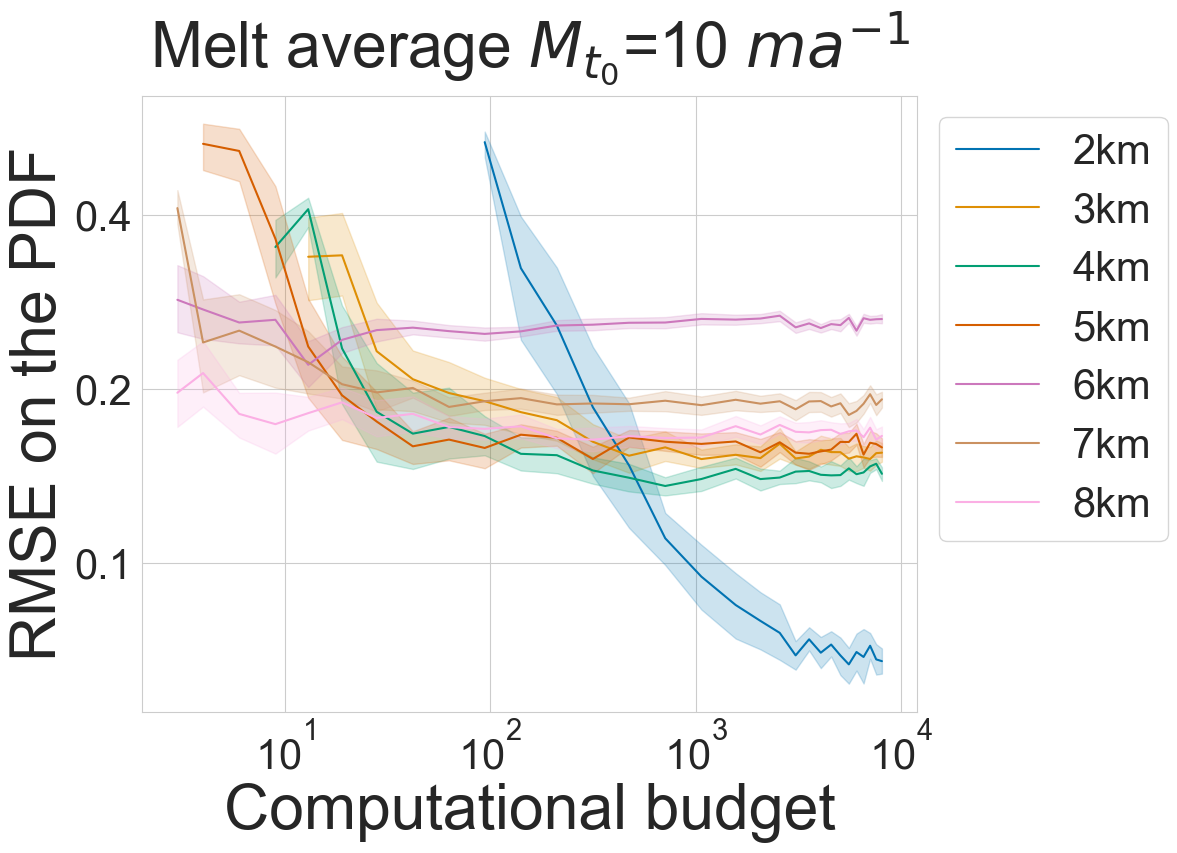

20
./../assets/plots/fig_6/comp_20_v2.pdf


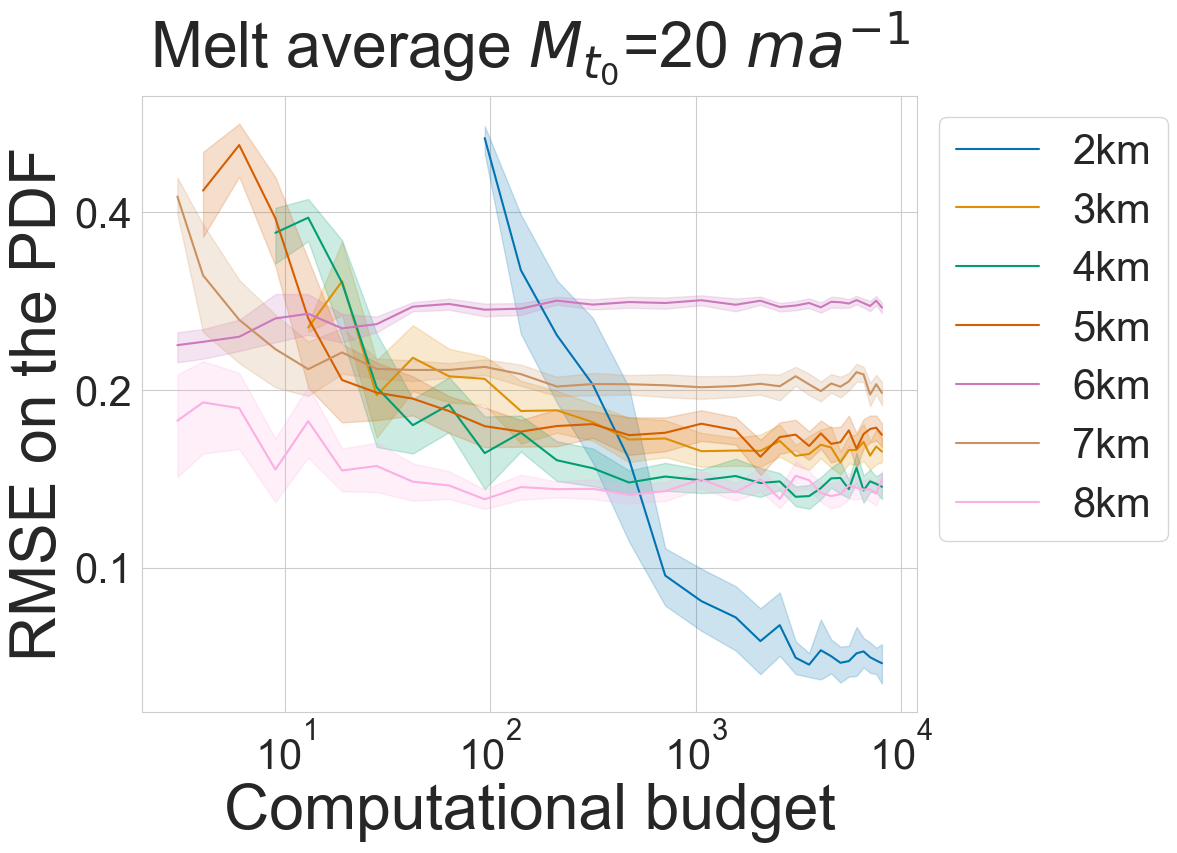

40
./../assets/plots/fig_6/comp_40_v2.pdf


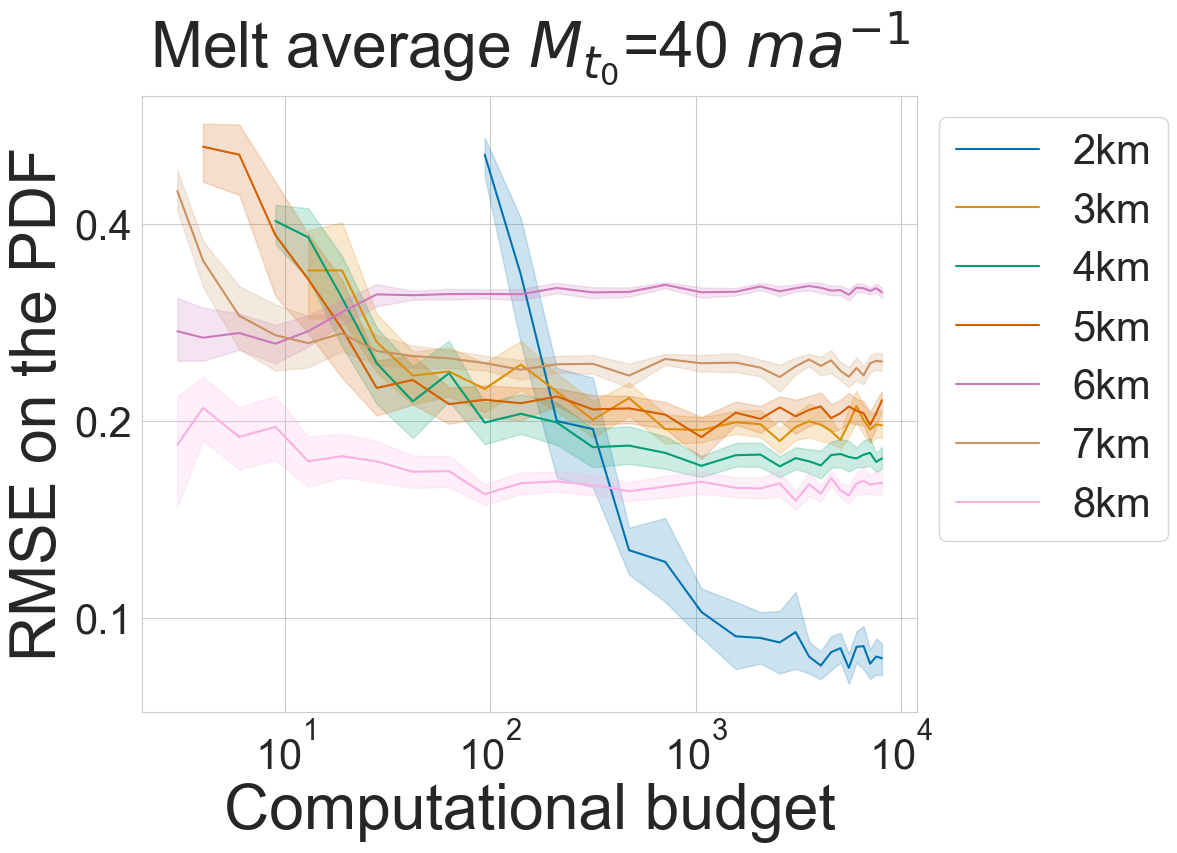

In [35]:
import pandas as pd

# Initialize an empty list to store the data
data_for_df = []
# Iterate through the pdf_errors dictionary to extract the necessary information
for melt_label, res_dict in pdf_errors.items():
    for res, budget_dict in res_dict.items():
        for budget, error_list in budget_dict.items():
            # For each error in the error_list, append a new record to the list
            if error_list is not None:
                for error in error_list:
                    data_for_df.append({
                        "res": str(res)+"km",
                        "budget": budget,
                        "melt_label": melt_label,
                        "error": error
                    })

# Convert the list of data into a pandas DataFrame
pdf_errors_df = pd.DataFrame(data_for_df)

# Display the first few rows of the DataFrame to verify
print(pdf_errors_df.head())


sns.set_palette('colorblind')
sns.set_style('whitegrid')
mpl.rcParams['font.family'] = 'Arial'

for label in pdf_errors_df['melt_label'].unique():
    print(label)
    plt.figure(figsize=(10,8))
    sns.lineplot(data=pdf_errors_df[pdf_errors_df['melt_label'] == label], x="budget", y="error", hue="res")
    plt.xscale('log')
    plt.yscale('log')
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.xlabel("Computational budget", fontsize=45)
    plt.ylabel("RMSE on the PDF", fontsize=45)
    plt.legend(bbox_to_anchor=(1.35, 1), loc='upper right', fontsize=30, title_fontsize=45)
    plt.title(f"Melt average "+r'$M_{t_0}$'+f"={label} "+ r'$ma^{-1}$', fontsize=45, pad=20)

    # Set specific ticks on the y axis
    ax = plt.gca()
    ax.set_yticks([0.1, 0.2, 0.4])
    ax.set_yticklabels(['0.1', '0.2', '0.4'])

    # Remove minor ticks
    ax.yaxis.set_minor_locator(plt.NullLocator())

    # Ensure the grid is visible for major ticks only
    ax.grid(True, which='major', linestyle='-', linewidth=0.8)

    # Adjust y-axis limits if necessary
    y_min, y_max = ax.get_ylim()
    ax.set_ylim(min(y_min, 0.1), max(y_max, 0.4))

    path = f"./../assets/plots/fig_6/comp_{str(label)}_v2.pdf"
    print(path)
    plt.savefig(path, bbox_inches='tight')
    plt.show()



In [19]:
res_list

[[[],
  [0.22776821547640697,
   0.17196776168390782,
   0.36284851403202767,
   0.43012640045973866,
   0.12120437122481766,
   0.30406044792334885,
   0.15355327569597255,
   0.3039964371798119,
   0.47615740584737615,
   0.4184655944863376,
   0.3395359487450131,
   0.5844469988449401,
   0.1913631126713408,
   0.3036366465568431,
   0.14508752537792405,
   0.28411627616184026,
   0.3631103854892863,
   0.17414466338450085,
   0.29150143511487636,
   0.1946892232306703,
   0.28409392966981467,
   0.1861422976006532,
   0.195587291588592,
   0.39947466636142853,
   0.4218927484310936,
   0.3990428672846514,
   0.30375533755964035,
   0.12058785421472203,
   0.2776652684762049,
   0.17285672578951636,
   0.1671089582680094,
   0.12122543445585332,
   0.29205012438621625,
   0.17873277256026704,
   0.10428076644678927,
   0.20390535129443177,
   0.49085337028713133,
   0.3982750535565406,
   0.49629296246921584,
   0.3991647721989284,
   0.1726536875993635,
   0.19097511174725768,
   0

In [9]:
# Def calculate the optimal value
def calculate_optimal_density(data, sample_size, resolution=2, mean_melt=2.2):
    Y_min = 0
    Y_max = 400
    var_bool = True
    #for var_bool in [True,False]:
    data_list = []
    mean,var = predict_and_plot_SLC(data, 150, 600, resolution, plot=False, sample_size=sample_size, mean_prior=mean_melt)[1]
    for m,v in zip(mean,var):
        if var_bool:
            data_list += list(np.random.normal(m,np.sqrt(v),size=sample_size))
        else:
            data_list += list(np.random.normal(m,0,size=sample_size))
    X_lin = np.linspace(Y_min,Y_max,100)[:, np.newaxis]
    kde = KernelDensity(kernel='gaussian',bandwidth=1).fit(np.array(data_list).reshape((-1,1))) #you can supply a bandwidth

    log_density_values=kde.score_samples(X_lin)
    y_opt_pdf=np.exp(log_density_values)
    # Calculate optimal CDF
    max_val = 400
    x = []
    y = []
    for thres in range(0,max_val,5):
        # Count how many elements in data list are abov thres
        # and divide by the total number of elements
        # to get the percentage of elements above thres
        x.append(thres)
        y.append(len([i for i in data_list if i > thres])/len(data_list))
    y_opt_cdf = np.array(y)
    return y_opt_cdf, y_opt_pdf, data_list


def run(budget,res, y_opt_cdf, y_opt_pdf, observed_2k, plot=False, sample_mean=False,timestamp=199, sample_size=400):
    #res = 4
    #budget = 130
    cost = {2:70,3:12,4:8,5:4,6:3,7:2,8:1}
    num_points = budget//cost[res]
    if num_points < 2:
        return None, None, None, None

    if num_points > 100:
        num_points = 100
        #return None, None, None
    print("Number of points is:", num_points)
    X_m = np.random.lognormal(mean=mean_melt,sigma=0.5,size=num_points).reshape((-1,1))
    X_m = np.concatenate([X_m, np.ones((X_m.shape[0],1))*res],axis=1)
    runner = ice_sheet_runner(timestamp=timestamp)
    X = runner.X_clf.transform(X_m)
    Y = runner.run(X)
    X = X[:,0].reshape((-1,1))

    kernel = GPy.kern.RBF(input_dim=1,ARD=True,lengthscale=[1],variance=1)
    model_gpy = GPRegression(X,Y,kernel = kernel, normalizer=True,noise_var=1)
    model_gpy.optimize()

    X_m = np.random.lognormal(mean=mean_melt,sigma=0.5,size=sample_size).reshape((-1,1))
    X,Y,X_m = prep_data(data,X_m=X_m)
    #X_m = np.linspace(X_min,X_max,100) # uniform prior
    pred = model_gpy.predict(X_m.reshape((-1,1)))
    mean,var = pred
    data_list = []
    for m,v in zip(mean,var):
        if sample_mean:
            data_list += list(np.random.normal(m,0,size=1))

        else:
            data_list += list(np.random.normal(m,np.sqrt(v),size=sample_size))
    print("AAAA")
    print(wasserstein_distance(observed_2k,data_list ))

    Y_min = 0
    Y_max = 400
    X_lin = np.linspace(Y_min,Y_max,100)[:, np.newaxis]

    kde = KernelDensity(kernel='gaussian',bandwidth=1).fit(np.array(data_list).reshape((-1,1))) #you can supply a bandwidth
                                                                #parameter.

    log_density_values=kde.score_samples(X_lin)
    Y_pred=np.exp(log_density_values)
    error_pdf = np.abs(Y_pred-y_opt_pdf).sum()

    x = []
    y = []
    for thres in range(0,400,5):
        # Count how many elements in data list are abov thres
        # and divide by the total number of elements
        # to get the percentage of elements above thres
        x.append(thres)
        y.append(len([i for i in data_list if i > thres])/len(data_list))

    error_cdf = np.abs(y-y_opt_cdf).mean()
    return error_pdf,error_cdf , Y_pred, y

def run_simulation(y_opt_cdf, y_opt_pdf, observed_2k):
    res_list = []
    res_list_cdf = []
    timestamp = 150
    res_y_pdf = []
    res_y_cdf = []
    res_Y_pred = []
    print("Timestampt:", timestamp)
    rep = 1
    for res in [2,3,4,5,6,7,8]: #
        error_list = []
        error_list_cdf = []
        Y_pred_tmp = []
        for comp in np.arange(5000,5001,1):
            print("Resolution: ",res, "Budget: ",comp)
            t1 = time.time()
            error_comp = []
            error_comp_cdf = []
            Y_pred_list = []
            # use tqdm to show a progress bar

            def process_simulation(i):
                try:
                    error, error_cdf, Y_pdf, y_cdf = run(comp, res, y_opt_cdf, y_opt_pdf, observed_2k, timestamp=timestamp)
                    return error, error_cdf, Y_pdf, y_cdf
                except Exception as e:
                    print(f"Error in simulation {i}: {e}")
                    return None

            with Pool(5) as pool:
                results = list(tqdm(pool.imap(process_simulation, range(rep)), total=rep))

            for result in results:
                if result is not None:
                    error, error_cdf, Y_pdf, y_cdf = result
                    error_comp.append(error)  # Change this to use pdf instead of cdf
                    error_comp_cdf.append(error_cdf)
                    res_y_pdf.append(Y_pdf)
                    res_y_cdf.append(y_cdf)
            if None in error_comp:
                error_list.append(10)
                error_list_cdf.append(10)
            else:
                error_list.append(error_comp)
                error_list_cdf.append(error_comp_cdf)
            Y_pred_tmp.append(Y_pred_list)
            print("Time: ",time.time()-t1)
        #print("Resolution: ",res,error_list)
        res_list.append(error_list)
        res_Y_pred.append(Y_pred_tmp)
        res_list_cdf.append(error_list_cdf)

    pickle.dump((res_list,res_Y_pred,res_list_cdf),open("fig_6_high.pkl","wb"))
    return res_list,res_Y_pred,res_list_cdf

       index  melt_exp  melt_average  melt_partial         SLC  resolution  \
15600      0       2.0           0.0           0.0   45.678647           2   
15601      1       2.0           0.0           0.0   33.907613           2   
15602      2       2.0           0.0           0.0   32.436782           2   
15603      3       2.0           0.0           0.0   55.983603           2   
15604      4       2.0           0.0           0.0   49.279017           2   
...      ...       ...           ...           ...         ...         ...   
15699     99       2.0         150.0           0.0  185.596435           2   
15700    100       2.0         150.0           0.0  189.181099           2   
15701    101       2.0         150.0           0.0  191.060903           2   
15702    102       2.0         150.0           0.0  190.420563           2   
15703    103       2.0         150.0           0.0  188.298973           2   

       years  
15600    150  
15601    150  
15602    150  
156

ValueError: Cannot take a larger sample than population when 'replace=False'

   res  budget  melt_label     error
0  2km      94          10  0.490078
1  2km      94          10  0.614902
2  2km      94          10  0.341173
3  2km      94          10  0.415768
4  2km      94          10  0.622006


10
./../assets/plots/fig_6/comp_10_v2.pdf
20
./../assets/plots/fig_6/comp_20_v2.pdf
40
./../assets/plots/fig_6/comp_40_v2.pdf


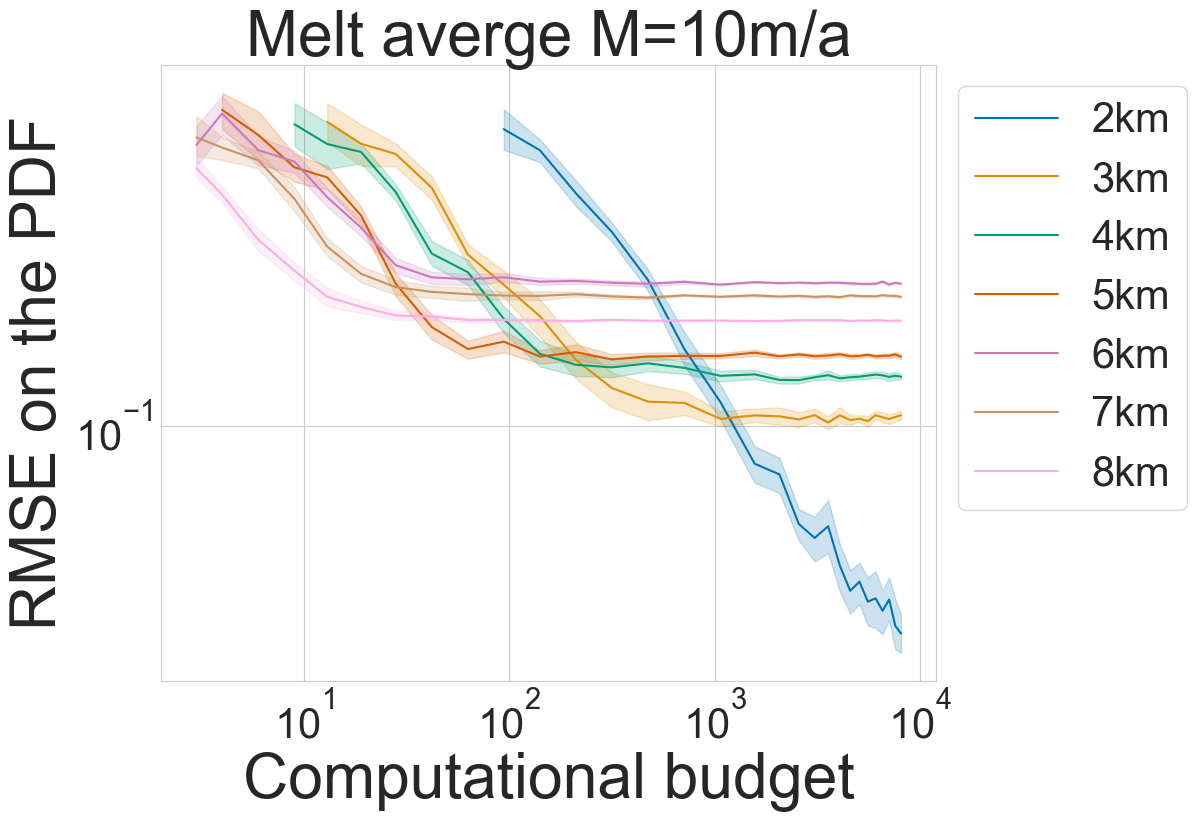

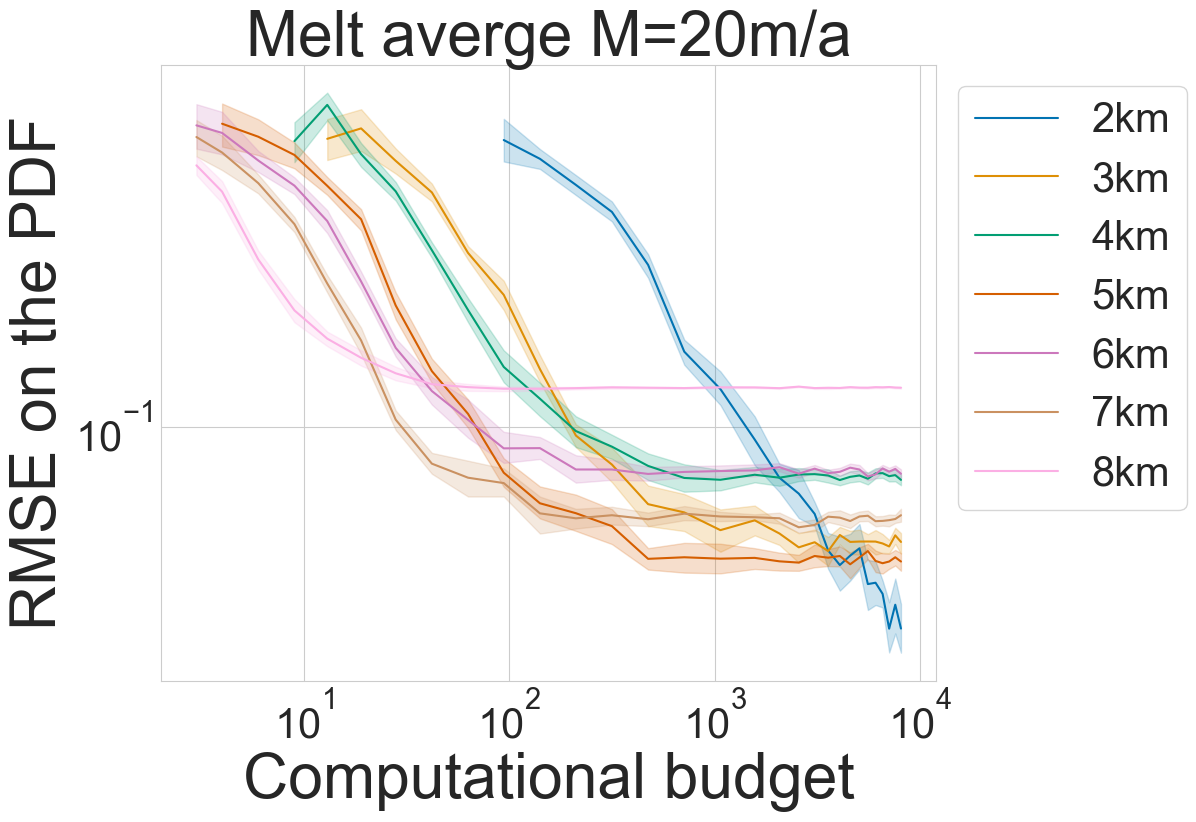

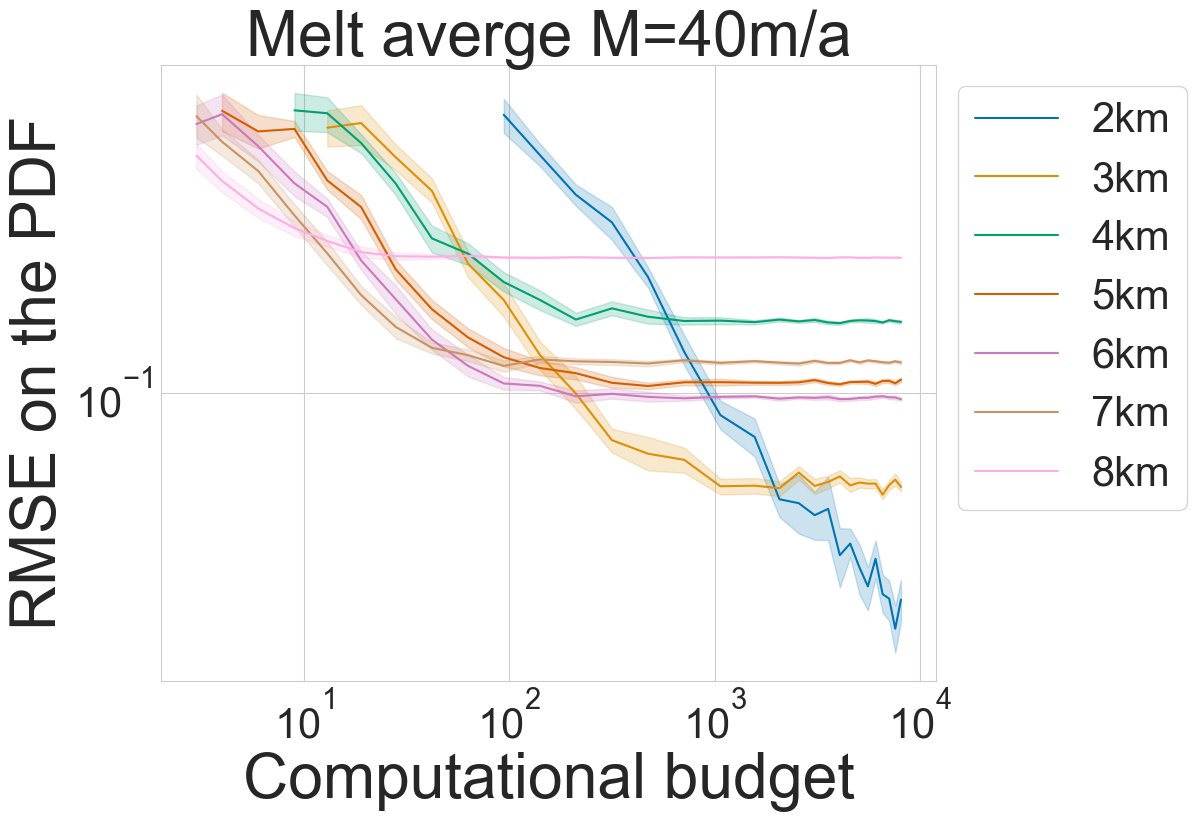

In [7]:

for mean_melt, melt_label in [(2.2,10),(2.872,20),(3.285,30),(3.52,40)]:
    data = mean_errors[melt_label]
    plt.figure(figsize=(10,8))
    ticksize=24
    label=29
    legend=24
    for i in range(2,9,1):
        x = [bud for bud in data[i].keys()]
        y = [val for val in data[i].values()]
        plt.plot(x,y,label=str(i)+"km")
    # place legend in top right outside plot
        plt.legend(bbox_to_anchor=(1.25, 1), loc='upper right', borderaxespad=0., fontsize=legend)
    #plt.legend()
    plt.xlabel("Computational budget", fontsize=label)
    plt.ylabel("Wasserstein distance", fontsize=label)
    plt.xscale('log')
    plt.yscale('log')
    plt.xticks(fontsize=ticksize)
    plt.yticks(fontsize=ticksize)
    plt.title(f"Melt average M={melt_label}", fontsize=label)
    plt.savefig(f"./../assets/plots/fig_6/comp_{melt_label}_v2.pdf",bbox_inches='tight')

    plt.show()

NameError: name 'mean_errors' is not defined

In [17]:
res_2_2= mean_errors.copy()

In [6]:
sample_size = 400 # TEST SIZE, if you want real plots s=3000
y_opt_cdf, y_opt_pdf, observed_2k = calculate_optimal_density(data, 1000)

In [16]:
import pathlib
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pathlib
from GPy.models import GPRegression
import GPy
import matplotlib.gridspec as gridspec
import pickle
import matplotlib.colors as mcolors
from sklearn.neighbors import KernelDensity
import sys
sys.path.insert(0, "./../")
import random
from src.utils import load_data, prep_data, predict_and_plot_SLC
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette('colorblind')
mpl.rcParams['font.family'] = 'Arial'

# Load data
#data = load_data([0,176])


use_cached_data = True
if use_cached_data:
    res_list,res_Y_pred,res_list_cdf = pickle.load(open("./../assets/plots_data/fig_6.pkl","rb"))
else:
    res_list,res_Y_pred,res_list_cdf = run_simulation(y_opt_cdf, y_opt_pdf, observed_2k)

In [2]:
print("C")

C


2
[0, 1, 2, 3, 4, 5, 6, 7, 8] [nan, 0.2417357639966151, 0.20837880056279073, 0.20154815057048228, 0.18094149496610784, 0.16417159672411383, 0.17999467076714015, 0.1768095296753886, 0.16652787765860247]
3
[0, 1, 2, 3, 4, 5, 6, 7, 8] [0.21867470735125313, 0.19936335743937084, 0.2033784750266058, 0.19707908972479132, 0.19813078092252123, 0.19743669419426285, 0.19771301927565277, 0.19415600813755524, 0.19305140464633397]
4
[0, 1, 2, 3, 4, 5, 6, 7, 8] [0.30606476308651875, 0.29990184020773836, 0.2993912301298903, 0.30273497593714893, 0.2981777950495083, 0.30270345837575785, 0.3016394907260637, 0.2999144221810408, 0.3055429388926378]
5
[0, 1, 2, 3, 4, 5, 6, 7, 8] [0.37665348398066106, 0.3718081981030118, 0.37180005890429835, 0.3694312965571014, 0.3695497440222262, 0.3656096283674884, 0.36612427602250586, 0.369748358105362, 0.3666944801506744]
6
[0, 1, 2, 3, 4, 5, 6, 7, 8] [0.40906533509524906, 0.4031357067193867, 0.40584161073669106, 0.40254435459342286, 0.40120420766678233, 0.39967861238939

 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning:Mean of empty slice.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide


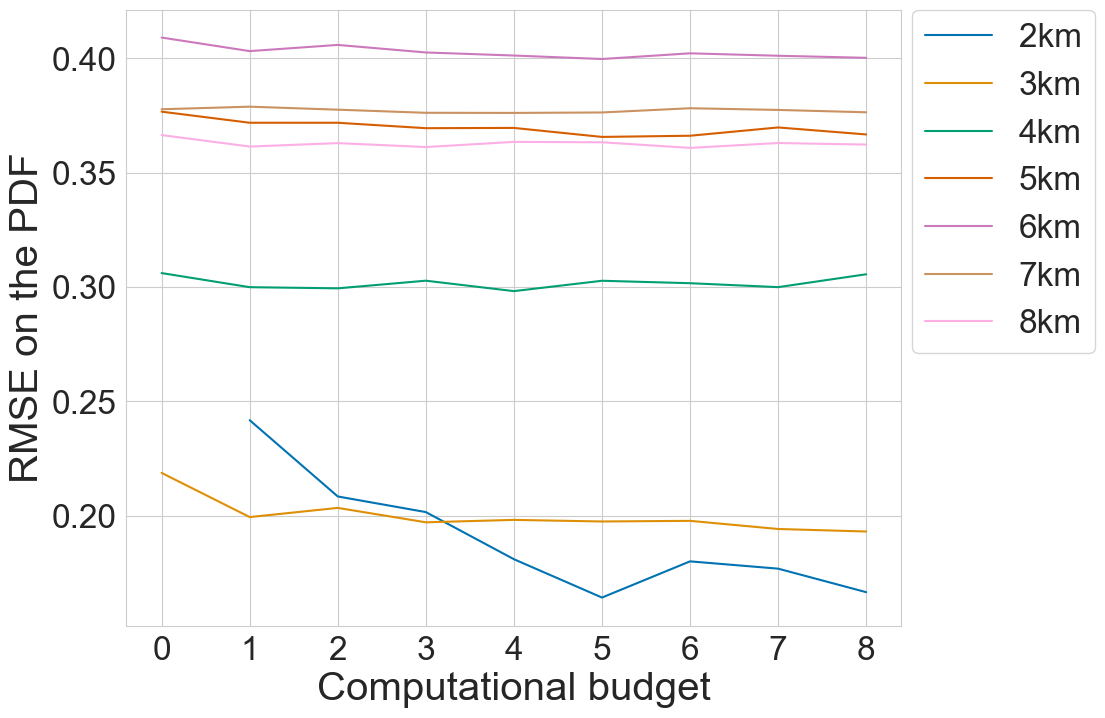

In [17]:
plt.figure(figsize=(10,8))
ticksize=24
label=29
legend=24
for c in [res_list]:
    for i,res in zip(c,[2,3,4,5,6,7,8]):
        x =[]
        y = []
        for idx,n in enumerate(i):
            n = np.median(n)
            if n != 10:
                x.append(idx)
                y.append(n)
        print(res)
        print(x,y)
        plt.plot(x,y,label=str(res)+"km")
    # place legend in top right outside plot
        plt.legend(bbox_to_anchor=(1.25, 1), loc='upper right', borderaxespad=0., fontsize=legend)
    #plt.legend()

    plt.xlabel("Computational budget",fontsize=label)
    plt.ylabel("RMSE on the PDF",fontsize=label)
    plt.xticks(fontsize=ticksize)
    plt.yticks(fontsize=ticksize)
    plt.savefig("./../assets/plots/fig_6/comp.pdf",bbox_inches='tight')

    plt.show()